# 0. Import

In [ ]:
import os
import sys
import csv
import json
import torch
import joblib
import pprint
import gymnasium
import highway_env
import numpy as np
import pandas as pd
import torch.distributions as td
import highway_env.utils_FlowIS as FlowIS

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from highway_env.Normalizing_Flow.maf import MAF
from highway_env.vehicle.behavior import IDMVehicle
from rl_agents.trainer.evaluation import Evaluation
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import norm, laplace, uniform, multivariate_normal
from rl_agents.agents.common.factory import load_agent, load_environment
from highway_env.utils_FlowIS import MarginalGaussianMixture,RejectAcceptSampling
from highway_env.utils_FlowIS import NormalProposalDistribution,MixedLaplaceUniform

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.edgecolor'] = 'black'

def custom_hist(samples, range, bins=40, weights=None):
    """
    Weighted histogram function with logic consistent with plt.hist:
    - Samples outside the specified range are completely ignored
    - Probability density is normalized based on in-range samples/weights (integral within range = 1)
    
    Parameters:
        samples: Collection of samples (1D array)
        range: Binning range (min, max)
        bins: Number of bins
        weights: Sample weights (same length as samples; None means equal weights for all samples)
    
    Returns:
        counts: Weighted sum within each bin (only includes in-range samples)
        densities: Normalized probability density (integral within range = 1)
        bin_edges: Boundaries of the bins
    """
    samples = np.asarray(samples)
    
    # Process weights
    if weights is None:
        weights = np.ones_like(samples, dtype=float)
    else:
        weights = np.asarray(weights, dtype=float)
        if len(weights) != len(samples):
            raise ValueError("Length of weights must match length of samples")
    
    # Extract and validate range
    min_val, max_val = range
    if min_val >= max_val:
        raise ValueError("Minimum value of range must be less than maximum value")
    
    # Filter samples and corresponding weights within the range (core: ignore out-of-range samples)
    in_range_mask = (samples >= min_val) & (samples <= max_val)
    filtered_samples = samples[in_range_mask]
    filtered_weights = weights[in_range_mask]
    
    # Calculate bin parameters
    bin_width = (max_val - min_val) / bins
    bin_edges = np.linspace(min_val, max_val, bins + 1)
    counts = np.zeros(bins, dtype=float)
    
    # Count weighted sum of in-range samples for each bin
    for sample, weight in zip(filtered_samples, filtered_weights):
        idx = int((sample - min_val) / bin_width)
        idx = np.clip(idx, 0, bins - 1)  # Prevent out-of-bounds caused by floating-point errors
        counts[idx] += weight
    
    # Calculate probability density (normalized by total weight of in-range samples, consistent with plt.hist)
    total_in_range_weight = np.sum(filtered_weights)
    if total_in_range_weight == 0:
        # If no samples are in range, set all densities to 0
        densities = np.zeros_like(counts)
    else:
        # Calculate density using only total weight of in-range samples (ensure integral within range = 1)
        densities = counts / (total_in_range_weight * bin_width)
    
    return counts, densities, bin_edges

def calculate_prob(scene_behavior, NDE_highway, Normalize=False):
    """
    Set Normalize=True when scene-behavior is in original value and needs normalization
    """
    if Normalize:
        scene_behavior = NDE_highway['fit_scene_behavior'].transform(scene_behavior)
    prob = NDE_highway['scene_behavior'].logpdf(scene_behavior)
    return prob

def calculate_ttc(scene, length):
    """
    Calculate Time to Collision (TTC) for rear-end collision scenarios, supporting batch processing
    
    Parameters:
        scene: 2D numpy array with shape (N, 3), where each row contains [rear vehicle speed, front vehicle speed, distance between two vehicles]
    
    Returns:
        2D numpy array with shape (N, 4), where the newly added 4th column contains the calculated TTC values
    """
    # Extract speeds and distance
    speed_rear = scene[:, 0]
    speed_front = scene[:, 1]
    distance = scene[:, 2] - length
    
    # Calculate speed difference
    speed_diff = speed_front - speed_rear
    
    # Handle cases where speed difference is non-negative (safe scenarios)
    safe_mask = speed_diff >= 0
    
    # Initialize TTC array: set TTC to 999 for safe scenarios, calculate TTC for dangerous scenarios
    ttc = np.empty_like(speed_diff, dtype=float)
    ttc[safe_mask] = 999
    ttc[~safe_mask] = distance[~safe_mask] / (-speed_diff[~safe_mask])
    
    # Add TTC as a new column and return
    return np.column_stack((scene, ttc))

def sample_distribution_ttc(distribution, distribution_p, num=1000000, bins=40, range=(0, 100), Normalize=False):
    if Normalize:
        # Sample scene-behavior data from the distribution
        scene_behavior = distribution['scene_behavior'].sample(num)
        # Inverse transform to convert normalized data back to original scale
        scene_behavior = distribution['fit_scene_behavior'].inverse_transform(scene_behavior)
        # Calculate TTC (vehicle length set to 5)
        ttc = calculate_ttc(scene_behavior, length=5)
        # Filter TTC values greater than 0.3
        ttc = ttc[ttc[:, 4] > 0.3]
        # Calculate log probabilities for distribution_p and distribution
        prob_p = calculate_prob(ttc[:, :4], distribution_p, Normalize=True)
        prob_q = calculate_prob(ttc[:, :4], distribution, Normalize=True)
        # Compute weights as exponential of probability difference
        weights = np.exp(prob_p - prob_q)     
        # Concatenate TTC data with weights (add weights as a new column)
        samples = np.concatenate([ttc, weights.reshape(-1, 1)], axis=1)
        # Generate weighted histogram for TTC
        custom_counts, custom_densities, custom_edges = custom_hist(samples[:, 4], range, bins, samples[:, 5])
    else:
        # Sample scene-behavior data from the distribution
        scene_behavior = distribution['scene_behavior'].sample(num)
        # Inverse transform to convert normalized data back to original scale
        scene_behavior = distribution['fit_scene_behavior'].inverse_transform(scene_behavior)
        # Calculate TTC (vehicle length set to 5)
        ttc = calculate_ttc(scene_behavior, length=5)
        # Filter TTC values greater than 0.3
        ttc = ttc[ttc[:, 4] > 0.3]
        # Extract TTC values as samples (no weights)
        samples = ttc[:, 4]
        weights = None
        # Generate unweighted histogram for TTC
        custom_counts, custom_densities, custom_edges = custom_hist(samples, range, bins, weights)
    return custom_counts, custom_densities, custom_edges

def remove_nan_samples(x, min_val=0.0, max_val=1.0):
    """
    Remove samples from a tensor that contain NaN values or values outside the specified range
    
    Parameters:
        x: Input tensor with shape [batch_size, ...]
        min_val: Lower bound of the valid value range
        max_val: Upper bound of the valid value range
    
    Returns:
        Filtered tensor containing only valid samples
    """
    # Check if each sample contains any NaN value
    has_nan = torch.isnan(x).any(dim=1)
    
    # Check if each sample contains any value outside the specified range
    out_of_range = ((x < min_val) | (x > max_val)).any(dim=1)
    
    # Condition for valid samples: no NaN values and no values outside the range
    valid_mask = ~(has_nan | out_of_range)
    
    # Return the tensor filtered by valid samples
    return x[valid_mask]

# 1. Data Processing

### 1.1 highway-NDEs

In [ ]:
"""
跟车的基本数据格式：
av[[present,ego-x,ego-y,ego-vx,ego-vy,ego-ac,ego-st],
bv [present,vf-x,vf-y,vf-vx,vf-vy,vf-ac,vf-st]]
"""
highD_carfollow=pd.read_csv(r'D:\LocalSyncdisk\加速测试\code\python仿真环境\仿真数据\carfollow_dataset.csv')
highD_carfollow.drop('Unnamed: 0',axis=1,inplace=True)
highD_carfollow=highD_carfollow.values
# highD_carfollow[:, 2] = np.clip(highD_carfollow[:, 2], 4.8, 100)
highD_carfollow=highD_carfollow[(highD_carfollow[:, 2] >= 4.8) & 
                                (highD_carfollow[:, 2] <= 100) &
                                (highD_carfollow[:, 3] >= -5 ) ]
highD_carfollow_ttc=calculate_ttc(highD_carfollow[:,0:4],4.8)
# speed_av,speed_bv,dis,a
Normalize_scene_behavior=MinMaxScaler()
Normalize_scene=MinMaxScaler()
Normalize_scene_behavior.fit(highD_carfollow[:,0:4])
Normalize_scene.fit(highD_carfollow[:,0:3])
scene_behavior_follow=Normalize_scene_behavior.fit_transform(highD_carfollow[:,0:4])
scene_follow=Normalize_scene.fit_transform(highD_carfollow[:,0:3])

# 拟合模型
# gmm_inter=FlowIS.MarginalGaussianMixture(n_components=15, random_state=42)
# gmm_inter.fit(scene_behavior_follow)
gmm_inter = FlowIS.MarginalTruncatedGMM(n_components=15,
                                        random_state=42,
                                        bounds=[(0, 1),(0, 1), (0, 1), (0, 1)],
                                        precompute_dims=[[0, 1, 2]])
gmm_inter.fit(scene_behavior_follow)

In [82]:
gmm_inter = FlowIS.MarginalTruncatedGMM(n_components=10,
                                        random_state=42,
                                        bounds=[(0, 1),(0, 1), (0, 1), (0, 1)],
                                        precompute_dims=[[0, 1, 2]])
gmm_inter.fit(scene_behavior_follow)

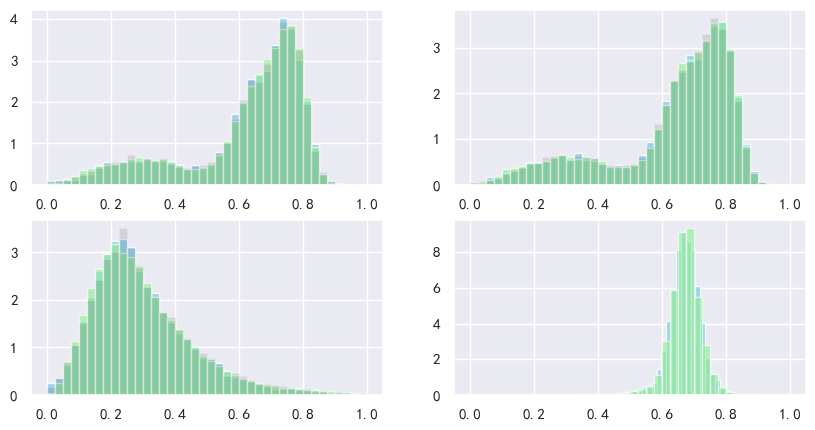

In [98]:
# 从边缘分布可视化验证
samples=gmm_inter.sample(10000)
samples_marginal=gmm_inter.sample_marginal(10000,dims=[0,1,2])
fig, axes = plt.subplots(2, 2, figsize=(10, 5)) 
num_un=num_pa=0
for i in range(2):
    for j in range(2):  
        axes[i, j].hist(samples[:,2*i+j],density=True,bins=40,color='skyblue', alpha=0.8)
        axes[i, j].hist(scene_behavior_follow[:,2*i+j],density=True,bins=40,color='lightgreen', alpha=0.6)
        try:
            axes[i, j].hist(samples_marginal[:,2*i+j],density=True,bins=40,color='black', alpha=0.1)
        except:
            pass


0.99863


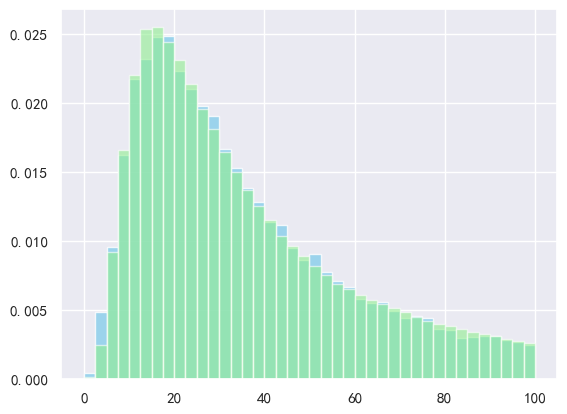

In [107]:
# 原始数据集TTC与采样TTC

NDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')
accept=0
ttc_list=[]
for _ in range(100000):
    # scene_behavior=gmm_inter.sample(n_samples=1)
    # scene_behavior=Normalize_scene_behavior.inverse_transform(scene_behavior)
    scene_behavior=NDE_highway['scene_behavior'].sample(n_samples=1)
    scene_behavior=NDE_highway['fit_scene_behavior'].inverse_transform(scene_behavior)
    ttc=calculate_ttc(scene_behavior,4.8)[0][4]
    if ttc>2:
        ttc_list.append(ttc)           
        accept+=1

print(accept/100000)
b=plt.hist(ttc_list,density=True,bins=40,color='skyblue', alpha=0.8,range=(0,100))
a=plt.hist(highD_carfollow_ttc[:,4],density=True,bins=40,color='lightgreen', alpha=0.6, range=(0,100))

验证归一化条件: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


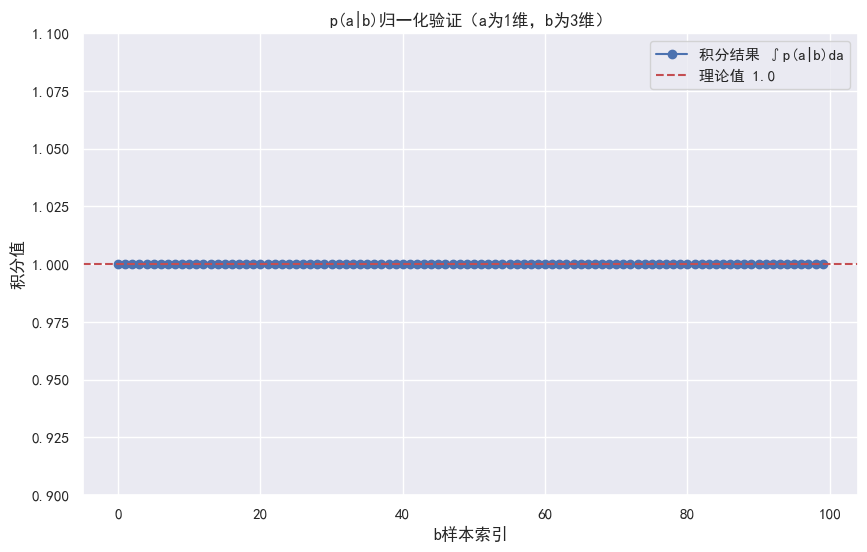

有效样本数：100/100
平均积分值：1.000008
积分标准差：0.000020
最大偏差：0.000142
是否严格满足归一化条件：是


In [ ]:
# Verify if the conditional distribution satisfies the normalization condition
def verify_conditional_normalization(gmm_joint,  # GMM model for the 4-dimensional joint distribution p(a,b)
                                     dim=[0,1,2],
                                     a_range=(0, 1),  # Value range of a (adjust based on actual scenario)
                                     b_samples=None,   # 3-dimensional samples of b (can be customized)
                                     num_a_points=1000,  # Number of discrete points for a
                                     num_b_samples=50):  # Number of samples for b
    """
    Verify the normalization condition of p(a|b): ∫p(a|b)da = 1
    
    Parameters:
    - gmm_joint: GMM model fitted to p(a,b) (4-dimensional: a(1D) + b(3D))
    - a_range: Integration range of a (min, max)
    - b_samples: 3-dimensional samples of b (automatically generated if None)
    - num_a_points: Number of discrete points for a (higher value means higher precision)
    - num_b_samples: Number of samples to generate for b
    """
    # 1. Generate samples for b (3-dimensional)
    if b_samples is None:
        # If b samples are not provided, sample from the marginal distribution of b in GMM
        # (Assume b corresponds to dimensions [1,2,3], and a corresponds to dimension 0)
        # Note: Adjust 'dims' according to your GMM dimension definition (here, a is dimension 0, b is dimensions 1-3)
        b_samples = gmm_joint.sample_marginal(n_samples=num_b_samples, dims=dim)
    
    # 2. Discretize the integration interval of a
    a_min, a_max = a_range
    a_values = np.linspace(a_min, a_max, num_a_points)  # Discrete points for 1-dimensional a
    delta_a = (a_max - a_min) / (num_a_points - 1)  # Integration step size
    
    # 3. For each b sample, calculate ∫p(a|b)da
    integrals = []
    for b in tqdm(b_samples, desc="Verifying normalization condition"):
        # Reshape b from (3,) to (1,3) to match GMM input format
        b = b.reshape(1, -1)
        
        # Calculate marginal probability p(b): log(p(b)) -> p(b)
        log_p_b = gmm_joint.logpdf_marginal(b, dims=dim)  # b corresponds to dimensions 1-3
        p_b = np.exp(log_p_b)
        if p_b < 1e-15:  # Avoid numerical instability caused by extremely small p(b)
            integrals.append(np.nan)
            continue
        
        # Calculate p(a|b) = p(a,b)/p(b) for each a
        p_a_given_b_list = []
        for a in a_values:
            # Construct input for the joint distribution: (a, b0, b1, b2) -> shape (1,4)
            a_b = np.concatenate([b[0], [a]], axis=0).reshape(1, -1)
            
            # Calculate joint probability p(a,b)
            log_p_ab = gmm_joint.logpdf(a_b)  # Full-dimensional calculation
            p_ab = np.exp(log_p_ab)
            
            # Calculate conditional probability p(a|b)
            p_a_given_b = p_ab / p_b
            p_a_given_b_list.append(p_a_given_b)
        
        # 4. Numerical integration: sum(p(a|b) * delta_a)
        integral = np.sum(p_a_given_b_list) * delta_a
        integrals.append(integral)
    
    # 5. Result visualization and statistics
    plt.figure(figsize=(10, 6))
    plt.plot(integrals, 'o-', label='Integration result ∫p(a|b)da')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Theoretical value 1.0')
    plt.xlabel('b sample index')
    plt.ylabel('Integration value')
    plt.ylim(0.9, 1.1)
    plt.title(f'Normalization Verification of p(a|b) (a: 1D, b: 3D)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Statistical indicators (exclude NaN values)
    valid_integrals = np.array(integrals)[~np.isnan(integrals)]
    mean = np.mean(valid_integrals)
    std = np.std(valid_integrals)
    max_deviation = np.max(np.abs(valid_integrals - 1.0))
    
    print(f"Number of valid samples: {len(valid_integrals)}/{num_b_samples}")
    print(f"Mean integration value: {mean:.6f}")
    print(f"Standard deviation of integration: {std:.6f}")
    print(f"Maximum deviation: {max_deviation:.6f}")
    
    # Determine if normalization is satisfied (allow minor numerical errors)
    is_normalized = np.allclose(valid_integrals, 1.0, atol=1e-2)
    print(f"Strictly satisfies normalization condition: {'Yes' if is_normalized else 'No'}")
    
    return integrals, is_normalized

integrals, is_normalized = verify_conditional_normalization(gmm_inter, 
                                                             a_range=(0, 1),  
                                                             b_samples=None,  
                                                             num_a_points=1000, 
                                                             num_b_samples=100)

In [ ]:
# Observe p(b|s) to design the proposed distribution
log_as_all_=[]
for _ in tqdm(range(1000)) :
    log_as=[]
    scene=gmm_inter.sample_marginal(n_samples=1, dims=[0,1,2])
    log_p_s=gmm_inter.logpdf_marginal(scene, dims=[0,1,2])
    behavior_list_ = np.linspace(0, 1, 101)
    for behavior in behavior_list_:
        scene_behavior=np.concatenate([scene[0], [behavior]],axis=0).reshape(1,-1)
        log_p_sb=gmm_inter.logpdf(scene_behavior.reshape(1,-1))
        log_p_b=log_p_sb-log_p_s
        log_as.append(log_p_b)
    log_as_all_.append(log_as)
log_as_all_=np.array(log_as_all_)
log_as_all_=log_as_all_.squeeze()

100%|██████████| 1000/1000 [01:09<00:00, 14.49it/s]


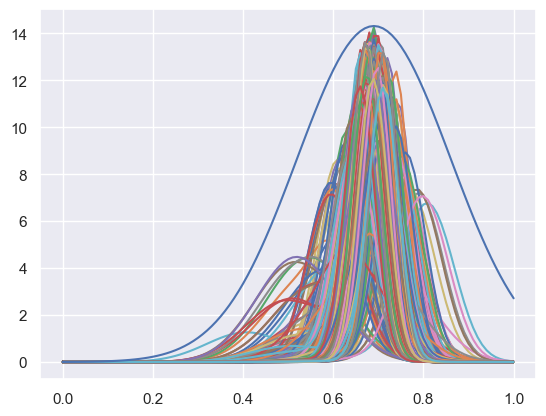

In [ ]:
for i in range(len(log_as_all_)):
    plt.plot(behavior_list_,np.exp(log_as_all_[i]))

M=6.1
proposal_accelerate=FlowIS.NormalProposalDistribution(mean=0.69, std=0.17)
plt.plot(behavior_list_,M*np.exp(proposal_accelerate.logpdf(behavior_list_)))

In [ ]:
# Sampling efficiency test
from highway_env.vehicle.sampling import RejectAcceptSampling
NDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')

rates=0
for i in range(100):
    scene=NDE_highway['scene_behavior'].sample_marginal(n_samples=1, dims=[0,1,2])
    rate=RejectAcceptSampling.rejection_sampling_1D(scene,NDE_highway,
                                                    dim=[0,1,2],
                                                    max_trials=100, random_state=None,
                                                    type='test')
    rates+=rate
rates/100

0.17010000000000006

In [ ]:
# Store the valid dictionary after completing all the processes.
NDE_highway=dict()
NDE_highway={'scene_behavior':gmm_inter, # scnen-behavior joint distribution
             'fit_scene_behavior':Normalize_scene_behavior,
             'fit_scene':Normalize_scene,
             'proposal_accelerate':proposal_accelerate,
             'proposal_M':M
             }

joblib.dump(NDE_highway,r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')



['D:\\LocalSyncdisk\\加速测试\\code\\highway版本\\模型参数集合\\NDE_highway.joblib']

### 1.2 highway-FlowIS

In [ ]:
def random_split_array(arr, ratio=0.7):
    """
    Randomly split an array into two parts, with the split ratio controlled by the 'ratio' parameter
    
    Parameters:
        arr: Input NumPy array
        ratio: Proportion of the first part (range: [0, 1])
        
    Returns:
        tuple: Two arrays after splitting
    """
    # Convert input to a valid NumPy array (in case the input is not already a NumPy array)
    arr = np.asarray(arr)
    
    # Check if the split ratio is valid
    if not (0 <= ratio <= 1):
        raise ValueError("Split ratio must be within the range [0, 1]")
    
    # Calculate the number of samples for the first part
    total_samples = arr.shape[0]
    part1_size = int(total_samples * ratio)
    
    # Generate random permutation of indices to ensure random splitting
    indices = np.random.permutation(total_samples)
    
    # Split the array using the randomly permuted indices
    part1 = arr[indices[:part1_size]]  # First part (size = part1_size)
    part2 = arr[indices[part1_size:]]  # Second part (remaining samples)
    
    return part1, part2

highD_carfollow=pd.read_csv(r'D:\LocalSyncdisk\加速测试\code\python仿真环境\仿真数据\carfollow_dataset.csv')
highD_carfollow.drop('Unnamed: 0',axis=1,inplace=True)
highD_carfollow=highD_carfollow.values
highD_carfollow=highD_carfollow[(highD_carfollow[:, 2] >= 4.8) & 
                                (highD_carfollow[:, 2] <= 100) &
                                (highD_carfollow[:, 3] >= -5 ) ]
Normalize_scene_behavior=MinMaxScaler()
Normalize_scene=MinMaxScaler()
Normalize_scene_behavior.fit(highD_carfollow[:,0:4])
Normalize_scene.fit(highD_carfollow[:,0:3])
# part1,part2=random_split_array(highD_carfollow, ratio=0.99)
# part1=part1[part1[:,4]<10]

scene_behavior_is_new = np.load( r'E:\加速测试仿真数据\FlowIS\critical\highway_scene_behavior_tuning.npy' )
scene_behavior_is = np.concatenate([highD_carfollow,scene_behavior_is_new[:,:5]],axis=0)
mask=scene_behavior_is[:,4]<1
scene_behavior_is=scene_behavior_is[mask]
scene_behavior_follow=Normalize_scene_behavior.transform(scene_behavior_is[:,0:4])
scene_follow=Normalize_scene.transform(scene_behavior_is[:,0:3])
scene_behavior_train = np.hstack((scene_behavior_follow, np.exp(-scene_behavior_is[:,[4]]/10)))


In [ ]:
epoch_loss=[]
epochs=300
# NDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = MAF(n_blocks=5,input_size=3,hidden_size=32,n_hidden=16)
model = MAF(n_blocks=5, input_size=4, hidden_size=100, n_hidden=1, cond_label_size=None,
                        activation='relu', input_order='sequential', batch_norm=True)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
model.train()

for epoch in tqdm(range(epochs)):
    np.random.shuffle(scene_behavior_train)
    feature = torch.from_numpy(scene_behavior_train[:10000,:4]).float()
    ttc = torch.from_numpy(scene_behavior_train[:10000,4]).float()
    # TensorDataset and DataLoader
    dataset = TensorDataset(feature,ttc)
    batch_size = 200
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_loss=[]
    for i, data in enumerate(train_loader):
        if len(data) == 1:
            x, y = data[0], None
        else:
            x, y = data
            y = y.to(device)
        # prob_p=NDE_highway['scene_behavior'].logpdf(x)    
        x = x.view(x.shape[0], -1).to(device)
        prob_q=model.log_prob(x, None) 
        loss = (- y * prob_q ).mean(0)
        loader_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss.append(sum(loader_loss)/len(loader_loss))
    if epoch % 100 == 0:
        print('epoch {:3d} / {}; loss {:.4f}'.format(
            epoch, epochs, sum(loader_loss)/len(loader_loss)))
# plt.plot(epoch_loss)
# plt.savefig('plot.png')
# plt.close()
# Image(filename='plot.png')
torch.save(model.state_dict(), r"D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\flow\scene_behavior_highway.pth")

  0%|          | 1/300 [00:00<03:33,  1.40it/s]

epoch   0 / 300; loss -5.2358


 34%|███▎      | 101/300 [00:26<00:49,  4.02it/s]

epoch 100 / 300; loss -9.2377


 67%|██████▋   | 201/300 [00:52<00:27,  3.62it/s]

epoch 200 / 300; loss -9.2663


100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


KL (u || p) = 0.0002


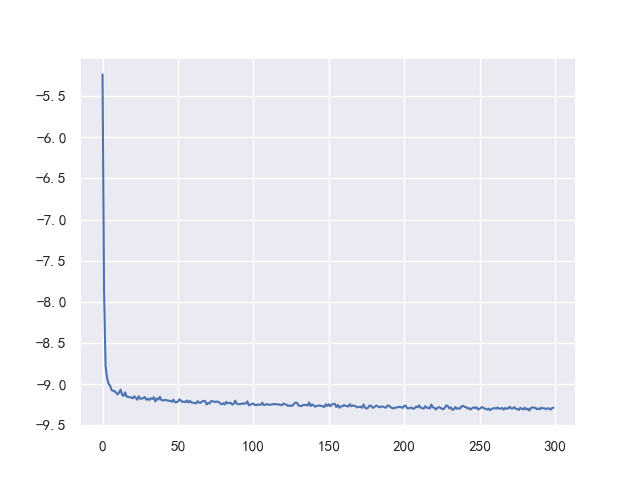

In [ ]:
from IPython.display import Image
def test_trained_model(model, dl,):
    # 1. sample toy data;
    # 2. run model forward and generate random numbers driving the model;
    # 3. measure KL between Gaussian fitted to random numbers driving the model and the base distribution
    model.to(device)
    data= next(iter(dl))
    u, logd = model.forward(data[0].to(device))
    u_dist = td.Normal(u.mean(0), u.std(0))
    kl = td.kl.kl_divergence(u_dist, model.base_dist).sum()
    print('KL (u || p) = {:.4f}'.format(kl))

test_trained_model(model,train_loader)
plt.figure()
plt.plot(epoch_loss)
plt.savefig('plot.png')
plt.close()
Image(filename='plot.png')

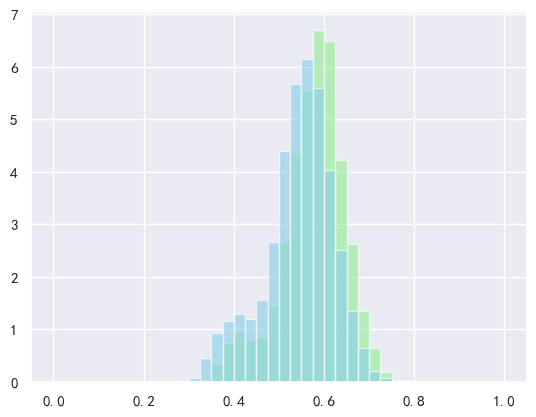

In [ ]:
from IPython.display import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = MAF(n_blocks=5,input_size=3,hidden_size=32,n_hidden=16)
model = MAF(n_blocks=5, input_size=4, hidden_size=100, n_hidden=1, cond_label_size=None,
                        activation='relu', input_order='sequential', batch_norm=True)
model = model.to(device)
model.load_state_dict(torch.load( r"D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\flow\scene_behavior_highway.pth"))
model.eval()  # 切换到评估模式
u = model.base_dist.sample((100000,)).squeeze()
samples, _ = model.inverse(u)
samples = remove_nan_samples(samples)
log_probs = model.log_prob(samples)  # sort by log_prob; take argsort idxs; flip high to low
log_probs=log_probs.sort(0)[1].flip(0).cpu()
samples=samples.cpu()
samples = samples[log_probs].detach().numpy()

i=3
plt.figure()
a=plt.hist(scene_behavior_follow[:,i],density=True,bins=40,color='lightgreen', alpha=0.6, range=(0,1))
b=plt.hist(samples[:,i],density=True,bins=40,color='skyblue', alpha=0.6, range=(0,1))


In [17]:
gmm_inter = FlowIS.MarginalTruncatedGMM(n_components=15,
                                        random_state=42,
                                        bounds=[(0, 1),(0, 1), (0, 1), (0, 1)],
                                        precompute_dims=[[0, 1, 2]])
gmm_inter.fit(samples)

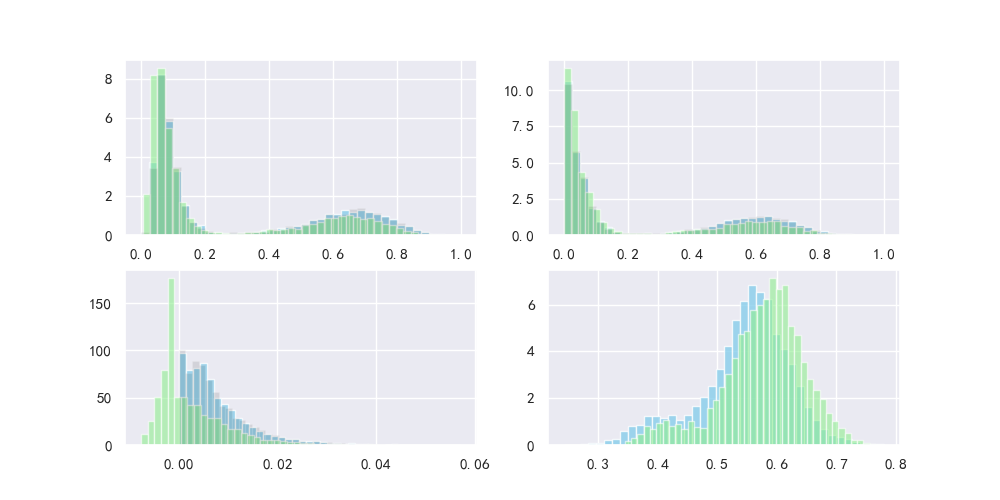

In [20]:
# 从边缘分布可视化验证
samples=gmm_inter.sample(10000)
samples_marginal=gmm_inter.sample_marginal(10000,dims=[0,1,2])
fig, axes = plt.subplots(2, 2, figsize=(10, 5)) 
num_un=num_pa=0
for i in range(2):
    for j in range(2):  
        axes[i, j].hist(samples[:,2*i+j],density=True,bins=40,color='skyblue', alpha=0.8)
        axes[i, j].hist(scene_behavior_follow[:,2*i+j],density=True,bins=40,color='lightgreen', alpha=0.6)
        try:
            axes[i, j].hist(samples_marginal[:,2*i+j],density=True,bins=40,color='black', alpha=0.1)
        except:
            pass
plt.savefig('plot.png')
plt.close()
Image(filename='plot.png')

验证归一化条件: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


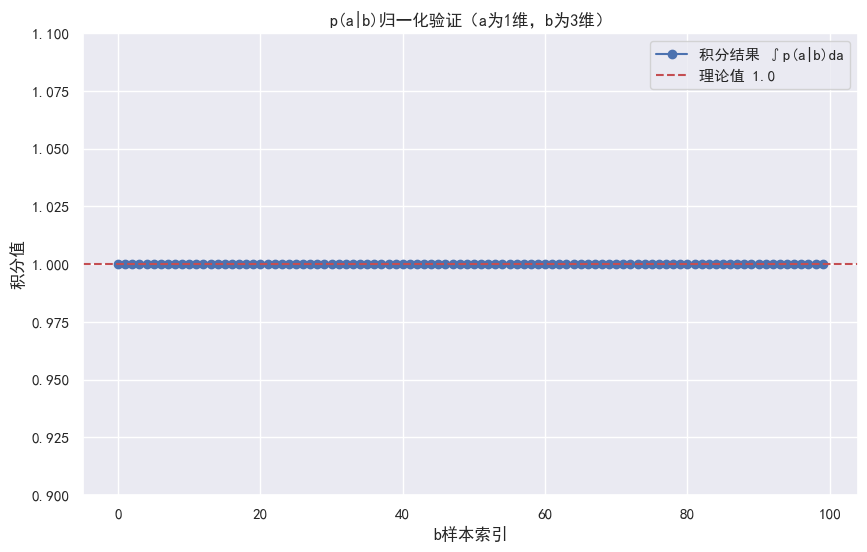

有效样本数：100/100
平均积分值：1.000000
积分标准差：0.000000
最大偏差：0.000000
是否严格满足归一化条件：是


In [ ]:
# Verify if the conditional distribution satisfies the normalization condition

def verify_conditional_normalization(gmm_joint,  # GMM model for the 4-dimensional joint distribution p(a,b)
                                     dim=[0,1,2],
                                     a_range=(0, 1),  # Value range of a (adjust based on actual scenarios)
                                     b_samples=None,   # 3-dimensional samples of b (can be customized)
                                     num_a_points=1000,  # Number of discrete points for a
                                     num_b_samples=50):  # Number of samples for b
    """
    Verify the normalization condition of p(a|b): ∫p(a|b)da = 1
    
    Parameters:
    - gmm_joint: GMM model fitted to p(a,b) (4-dimensional: a(1D) + b(3D))
    - a_range: Integration range of a (min, max)
    - b_samples: 3-dimensional samples of b (automatically generated if None)
    - num_a_points: Number of discrete points for a (higher value means higher precision)
    - num_b_samples: Number of samples to generate for b
    """
    # 1. Generate samples for b (3-dimensional)
    if b_samples is None:
        # If b samples are not provided, sample from the marginal distribution of b in GMM
        # (Assume b corresponds to dimensions [1,2,3], and a corresponds to dimension 0)
        # Note: Adjust 'dims' according to your GMM dimension definition (here, a is dimension 0, b is dimensions 1-3)
        b_samples = gmm_joint.sample_marginal(n_samples=num_b_samples, dims=dim)
    
    # 2. Discretize the integration interval of a
    a_min, a_max = a_range
    a_values = np.linspace(a_min, a_max, num_a_points)  # Discrete points for 1-dimensional a
    delta_a = (a_max - a_min) / (num_a_points - 1)  # Integration step size
    
    # 3. Calculate ∫p(a|b)da for each b sample
    integrals = []
    for b in tqdm(b_samples, desc="Verifying normalization condition"):
        # Reshape b from (3,) to (1,3) to match the input format of GMM
        b = b.reshape(1, -1)
        
        # Calculate marginal probability p(b): convert log(p(b)) to p(b)
        log_p_b = gmm_joint.logpdf_marginal(b, dims=dim)  # b corresponds to dimensions 1-3
        p_b = np.exp(log_p_b)
        if p_b < 1e-15:  # Avoid numerical instability caused by extremely small p(b)
            integrals.append(np.nan)
            continue
        
        # Calculate p(a|b) = p(a,b)/p(b) for each a value
        p_a_given_b_list = []
        for a in a_values:
            # Construct input for the joint distribution: (a, b0, b1, b2) -> shape (1,4)
            a_b = np.concatenate([b[0], [a]], axis=0).reshape(1, -1)
            
            # Calculate joint probability p(a,b)
            log_p_ab = gmm_joint.logpdf(a_b)  # Full-dimensional calculation
            p_ab = np.exp(log_p_ab)
            
            # Calculate conditional probability p(a|b)
            p_a_given_b = p_ab / p_b
            p_a_given_b_list.append(p_a_given_b)
        
        # 4. Numerical integration: sum(p(a|b) * delta_a)
        integral = np.sum(p_a_given_b_list) * delta_a
        integrals.append(integral)
    
    # 5. Visualize and statistically analyze the results
    plt.figure(figsize=(10, 6))
    plt.plot(integrals, 'o-', label='Integration result ∫p(a|b)da')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Theoretical value 1.0')
    plt.xlabel('b sample index')
    plt.ylabel('Integration value')
    plt.ylim(0.9, 1.1)
    plt.title(f'Normalization Verification of p(a|b) (a: 1D, b: 3D)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Statistical indicators (exclude NaN values)
    valid_integrals = np.array(integrals)[~np.isnan(integrals)]
    mean = np.mean(valid_integrals)
    std = np.std(valid_integrals)
    max_deviation = np.max(np.abs(valid_integrals - 1.0))
    
    print(f"Number of valid samples: {len(valid_integrals)}/{num_b_samples}")
    print(f"Mean integration value: {mean:.6f}")
    print(f"Standard deviation of integration: {std:.6f}")
    print(f"Maximum deviation: {max_deviation:.6f}")
    
    # Determine if normalization is satisfied (allow minor numerical errors)
    is_normalized = np.allclose(valid_integrals, 1.0, atol=1e-2)
    print(f"Strictly satisfies normalization condition: {'Yes' if is_normalized else 'No'}")
    
    return integrals, is_normalized

integrals, is_normalized = verify_conditional_normalization(gmm_inter, 
                                                             a_range=(0, 1),  
                                                             b_samples=None,  
                                                             num_a_points=1000, 
                                                             num_b_samples=100)



In [22]:
# 观察p(b|s)，用于设计提议分布
log_as_all_=[]
for _ in tqdm(range(10000)) :
    log_as=[]
    scene=gmm_inter.sample_marginal(n_samples=1, dims=[0,1,2])
    log_p_s=gmm_inter.logpdf_marginal(scene, dims=[0,1,2])
    behavior_list_ = np.linspace(0, 1, 101)  # 从0到1，共11个点（步长0.01）
    for behavior in behavior_list_:
        scene_behavior=np.concatenate([scene[0], [behavior]],axis=0).reshape(1,-1)
        log_p_sb=gmm_inter.logpdf(scene_behavior.reshape(1,-1))
        log_p_b=log_p_sb-log_p_s
        log_as.append(log_p_b)
    log_as_all_.append(log_as)
log_as_all_=np.array(log_as_all_)
log_as_all_=log_as_all_.squeeze()

100%|██████████| 10000/10000 [12:57<00:00, 12.86it/s]


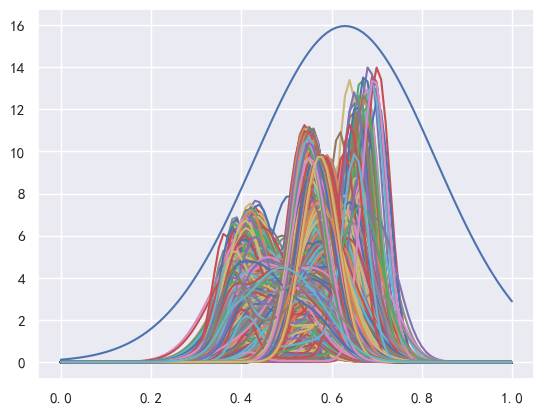

In [25]:
plt.figure()
for i in range(len(log_as_all_)):
    plt.plot(behavior_list_,np.exp(log_as_all_[i]))

M=8
proposal_accelerate=FlowIS.NormalProposalDistribution(mean=0.63, std=0.2)
plt.plot(behavior_list_,M*np.exp(proposal_accelerate.logpdf(behavior_list_)))

In [26]:
# 完成全部流程后存储有效的IS
FlowIS_highway=dict()
FlowIS_highway={'scene_behavior':gmm_inter, # 场景-行为联合分布，由高斯混合分布刻画
             'fit_scene_behavior':Normalize_scene_behavior,
             'fit_scene':Normalize_scene,
             'proposal_accelerate':proposal_accelerate,
             'proposal_M':M
             }

joblib.dump(FlowIS_highway,r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_highway_step2.joblib')


['D:\\LocalSyncdisk\\加速测试\\code\\highway版本\\模型参数集合\\FlowIS_highway_step2.joblib']

In [27]:
# 采样效率测试
from highway_env.vehicle.sampling import RejectAcceptSampling
FlowIS_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_highway_step2.joblib')

rates=0
for i in range(100):
    scene=FlowIS_highway['scene_behavior'].sample_marginal(n_samples=1, dims=[0,1,2])
    rate=RejectAcceptSampling.rejection_sampling_1D(scene,FlowIS_highway,
                                                    dim=[0,1,2],
                                                    max_trials=100, random_state=None,
                                                    type='test')
    rates+=rate
rates/100

0.12750000000000006

<BarContainer object of 40 artists>

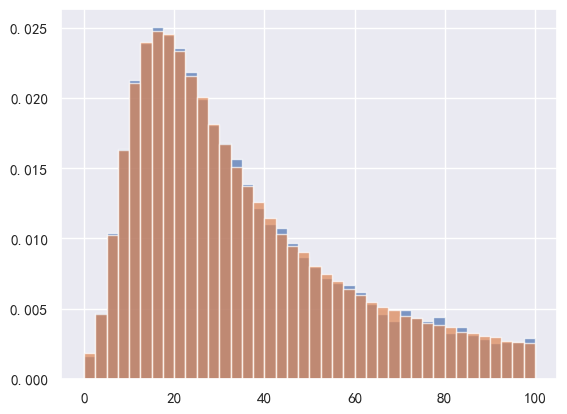

In [49]:
# TTC分布验证
FlowIS_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_highway_step2.joblib')
NDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')

# 重要度抽样分布无偏性验证（TTC）
custom_counts, custom_densities, custom_edges=sample_distribution_ttc(FlowIS_highway, distribution_p=NDE_highway, bins = 40, range = (0, 100), Normalize=True)
plt.bar(custom_edges[:-1], custom_densities, width=np.diff(custom_edges), align='edge', alpha=0.7, label='custom_hist')

custom_counts, custom_densities, custom_edges=sample_distribution_ttc(NDE_highway, distribution_p=NDE_highway, bins = 40, range = (0, 100), Normalize=False)
plt.bar(custom_edges[:-1], custom_densities, width=np.diff(custom_edges), align='edge', alpha=0.7, label='custom_hist')

# 2. ENV环境

### 主车智能DQN

In [1]:
# 主车智能
import os
import highway_env
import gymnasium
from rl_agents.agents.common.factory import load_agent, load_environment
from rl_agents.trainer.evaluation import Evaluation
agent_config = {
    "__class__": "<class 'rl_agents.agents.deep_q_network.pytorch.DQNAgent'>",
    "model": {
        "type": "MultiLayerPerceptron",
        "layers": [128, 128]
    },
    "gamma": 0.95,
    "n_steps": 1,
    "batch_size": 64,
    "memory_capacity": 15000,
    "target_update": 512,
    "exploration": {
        "method": "EpsilonGreedy",
        "tau": 15000,
        "temperature": 1.0,
        "final_temperature": 0.05
    }
}
env = gymnasium.make('HighDEnv-v0',render_mode='rgb_array') #'rgb_array'
agent = load_agent(agent_config, env)

evaluation = Evaluation(
    env, 
    agent, 
    num_episodes=100,
    directory=r"D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\agent\DQN",
    display_env=False,
    display_agent=False
)
evaluation.train()

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\rl_agents\agents\deep_q_network\pytorch.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return self.value_net(torch.tensor(states, dtype=torch.float).to(self.device)).data.cpu().numpy()
[INFO] Episode 0 score: 98.6 
[INFO] Saved DQNAgent model to D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\agent\DQN\run_20250714-153001_27208\checkpoint-0.tar 
[INFO] Episode 1 score: 97.7 
[INFO] Saved DQNAgent model to D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\agent\DQN\run_20250714-153001_27208\checkpoint-1.tar 
[INFO] Episode 2 score: 52.8 
[INFO] Episode 3 score: 98.3 
[INFO] Episode 4 score: 97.5 
[INFO] Episode 5 score: 40.0 
[INFO] Episode 6 score: 99.1 
[INFO] Episo

In [ ]:
import gymnasium
import os
import highway_env
from rl_agents.agents.common.factory import load_agent, load_environment
agent_config = {
    "__class__": "<class 'rl_agents.agents.deep_q_network.pytorch.DQNAgent'>",
    "model": {
        "type": "MultiLayerPerceptron",
        "layers": [128, 128]
    },
    "gamma": 0.95,
    "n_steps": 1,
    "batch_size": 64,
    "memory_capacity": 15000,
    "target_update": 512,
    "exploration": {
        "method": "EpsilonGreedy",
        "tau": 15000,
        "temperature": 1.0,
        "final_temperature": 0.05
    }
}
env = gymnasium.make('HighDEnv-v0',render_mode='rgb_array') #'rgb_array'
agent = load_agent(agent_config, env)
checkpoint_path=r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\agent\DQN\run_20250714-153001_27208\checkpoint-best.tar'
if os.path.exists(checkpoint_path):
    agent.load(checkpoint_path)
    print(f"已加载预训练权重: {checkpoint_path}")
else:
    print("未找到预训练权重，使用随机初始化的智能体")
agent.training=False    

simulation=[]
for i in range(1000):
    obs,info = env.reset()
    for _ in range(10):
        action=agent.act(obs)
        obs, reward, terminated, truncated, info =env.step(action)
        # if env.unwrapped.road.vehicles[0].crashed:
        #     break
        # env.render()
    if env.unwrapped.road.vehicles[0].crashed:
        simulation.append(1)        
    else:
        simulation.append(0)
    env.close()
    # sum(simulation)/len(simulation)

[INFO] Choosing GPU device: 0, memory used: 2347 


已加载预训练权重: D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\agent\DQN\run_20250714-153001_27208\checkpoint-best.tar


### FlowIS仿真

In [ ]:
import os
import joblib
import numpy as np
import gymnasium
from tqdm import tqdm
from scipy.special import ndtri

def calculate_prob(scene_behavior, NDE_highway, Normalize=False):
    """
    Set Normalize=True when scene-behavior is in original value and requires normalization
    """
    if Normalize:
        scene_behavior = NDE_highway['fit_scene_behavior'].transform(scene_behavior)
    prob = NDE_highway['scene_behavior'].logpdf(scene_behavior)
    return prob

def calculate_ttc(scene, length):
    """
    Calculate Time to Collision (TTC) for rear-end collision scenarios, supporting batch processing
    
    Parameters:
        scene: 2D numpy array with shape (N, 3), where each row contains [rear vehicle speed, front vehicle speed, distance between two vehicles]
    
    Returns:
        2D numpy array with shape (N, 4), where the newly added 4th column contains the calculated TTC values
    """
    # Extract speeds and distance
    speed_rear = scene[:, 0]
    speed_front = scene[:, 1]
    distance = scene[:, 2] - length
    
    # Calculate speed difference
    speed_diff = speed_front - speed_rear
    
    # Handle cases where speed difference is non-negative (safe scenarios)
    safe_mask = speed_diff >= 0
    
    # Initialize TTC array: set TTC to 999 for safe scenarios, calculate TTC for dangerous scenarios
    ttc = np.empty_like(speed_diff, dtype=float)
    ttc[safe_mask] = 999
    ttc[~safe_mask] = distance[~safe_mask] / (-speed_diff[~safe_mask])
    
    # Add TTC as a new column and return
    return np.column_stack((scene, ttc))

def importance_mapping(FlowIS_highway, NDE_highway, scene_behavior):
    # Normalize the scene-behavior data using the transformer from FlowIS_highway
    scene_behavior = FlowIS_highway['fit_scene_behavior'].transform(scene_behavior)
    # Extract the scene-related dimensions (columns 0, 1, 2) from scene_behavior
    scene = scene_behavior[:, [0, 1, 2]]
    
    # Calculate log-probability of joint distribution p(scene-behavior) under FlowIS_highway (take the first value)
    prob_q_s_b = FlowIS_highway['scene_behavior'].logpdf(scene_behavior)[0]
    # Calculate log-probability of marginal distribution p(scene) under FlowIS_highway (for dimensions [0,1,2])
    prob_q_s = FlowIS_highway['scene_behavior'].logpdf_marginal(scene, [0, 1, 2])  
    
    # Calculate log-probability of joint distribution p(scene-behavior) under NDE_highway (take the first value)
    prob_p_s_b = NDE_highway['scene_behavior'].logpdf(scene_behavior)[0]
    # Calculate log-probability of marginal distribution p(scene) under NDE_highway (for dimensions [0,1,2])
    prob_p_s = NDE_highway['scene_behavior'].logpdf_marginal(scene, [0, 1, 2])  
    
    # Return the importance weight (logarithmic form: log(p(s,b)/p(s)) - log(q(s,b)/q(s)))
    return prob_p_s_b - prob_p_s - prob_q_s_b + prob_q_s

result_=[]
scene_behavior_simulate=[]
TDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_highway.joblib')
NDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')

gymnasium.register(
    id='HighDEnv-v0',
    entry_point='highway_env.envs:HighDEnv',
)
env = gymnasium.make('HighDEnv-v0',render_mode='rgb_array')
# env.unwrapped.config.update({
#     "distribution": FlowIS_highway
# })
z_rate=0.95
step_lenth=10
half_width_base=1
file = 'highway_TDE_20250906'
folder_path = fr'E:\加速测试仿真数据\FlowIS\simulation\{file}'
os.makedirs(folder_path, exist_ok=True)
while half_width_base > 0.3: 
    for _ in tqdm(range(10000)):
        obs, info = env.reset()
        # initial scene
        scene_behavior=TDE_highway['fit_scene_behavior'].transform(np.array([info['scene_behavior']]))
        prob_s_q=TDE_highway['scene_behavior'].logpdf_marginal(scene_behavior[:,[0,1,2]], [0,1,2]) 
        prob_s_p=NDE_highway['scene_behavior'].logpdf_marginal(scene_behavior[:,[0,1,2]], [0,1,2]) 
        prob=prob_s_p-prob_s_q

        for _ in range(step_lenth):
            obs, reward, terminated, truncated, info = env.step(0)
            if terminated or truncated:
                break           
            # env.render()
            scene_behavior=np.array([info['scene_behavior']])
            prob+=importance_mapping(TDE_highway,NDE_highway,scene_behavior)
            ttc=calculate_ttc(scene_behavior,5)[0][4]
            scene_behavior_simulate.append(info['scene_behavior'])

        if env.unwrapped.road.vehicles[0].crashed:
            result_.append([1,ttc,np.exp(prob).item()])        
        else:
            result_.append([0,ttc,np.exp(prob).item()])
 
        env.close()

    result=np.array(result_)   
    result=result[:,0]*result[:,2]
    collision_rate=np.mean(result)
    z = ndtri(1 - (1 - z_rate) / 2)
    if collision_rate != 0:
        half_width_base = z * np.std(result) / np.sqrt(len(result)) / collision_rate
    else:
        half_width_base = 1    
    print('simulation:',len(result),'    collision:',collision_rate,'    half_width:',half_width_base)
    joblib.dump(scene_behavior_simulate, os.path.join(folder_path, 'scene_behavior.joblib'))
    joblib.dump(result_,os.path.join(folder_path, 'result.joblib'))
    # joblib.dump(simulation,r'E:\加速测试仿真数据\FlowIS\FlowIS_highway_20250811.joblib')
    # scene_behavior_simulation=np.array(scene_behavior_simulate)
    # np.save(r'E:\加速测试仿真数据\FlowIS\highway_scene_behavior_20250811.npy', scene_behavior_simulation)


# 3. Display

### Draw

In [13]:
# funciton of index
import matplotlib.ticker as ticker
def custom_hist(samples, range, bins=40, weights=None):
    """
    与plt.hist逻辑一致的带权重直方图函数：
    - 超出range的样本完全忽略
    - 概率密度基于范围内的样本/权重归一化（范围内积分=1）
    
    参数:
        samples: 样本集合（一维数组）
        range: 分箱范围 (min, max)
        bins: 分箱数量
        weights: 样本权重（与samples同长度，None则为等权重）
    
    返回:
        counts: 分箱内的加权和（仅包含范围内样本）
        densities: 归一化的概率密度（范围内积分=1）
        bin_edges: 分箱边界
    """
    samples = np.asarray(samples)
    
    # 处理权重
    if weights is None:
        weights = np.ones_like(samples, dtype=float)
    else:
        weights = np.asarray(weights, dtype=float)
        if len(weights) != len(samples):
            raise ValueError("权重与样本长度必须一致")
    
    # 提取范围并验证
    min_val, max_val = range
    if min_val >= max_val:
        raise ValueError("范围最小值必须小于最大值")
    
    # 筛选范围内的样本和对应的权重（核心：忽略范围外样本）
    in_range_mask = (samples >= min_val) & (samples <= max_val)
    filtered_samples = samples[in_range_mask]
    filtered_weights = weights[in_range_mask]
    
    # 计算分箱参数
    bin_width = (max_val - min_val) / bins
    bin_edges = np.linspace(min_val, max_val, bins + 1)
    counts = np.zeros(bins, dtype=float)
    
    # 统计范围内样本的加权计数
    for sample, weight in zip(filtered_samples, filtered_weights):
        idx = int((sample - min_val) / bin_width)
        idx = np.clip(idx, 0, bins - 1)  # 防止因浮点误差导致的越界
        counts[idx] += weight
    
    # 计算概率密度（基于范围内的总权重归一化，与plt.hist一致）
    total_in_range_weight = np.sum(filtered_weights)
    if total_in_range_weight == 0:
        # 若范围内无样本，密度全部为0
        densities = np.zeros_like(counts)
    else:
        # 仅用范围内的总权重计算密度（确保范围内积分=1）
        densities = counts / (total_in_range_weight * bin_width)
    
    return counts, densities, bin_edges

def calculate_prob(scene_behavior,NDE_highway,Normalize=False):
    """
    当scene-behavior为原值，需要标准化时Normalize=True
    """
    if Normalize:
        scene_behavior=NDE_highway['fit_scene_behavior'].transform(scene_behavior)
    prob=NDE_highway['scene_behavior'].logpdf(scene_behavior)
    return prob

def calculate_ttc(scene,lenth):
    """
    计算追尾场景的碰撞时间(TTC)，支持批量处理
    
    参数:
        scene: 形状为(N, 3)的二维numpy数组，每行包含[后车速度, 前车速度, 两车距离]
    
    返回:
        形状为(N, 4)的二维numpy数组，新增的第四列为计算得到的TTC值
    """
    # 提取速度和距离
    speed_rear = scene[:, 0]
    speed_front = scene[:, 1]
    distance = scene[:, 2]-lenth
    
    # 计算速度差
    speed_diff = speed_front - speed_rear
    
    # 处理速度差非负的情况（安全场景）
    safe_mask = speed_diff >= 0
    
    # 初始化TTC数组，安全场景设为999，危险场景计算TTC
    ttc = np.empty_like(speed_diff, dtype=float)
    ttc[safe_mask] = 999
    ttc[~safe_mask] = distance[~safe_mask] / (-speed_diff[~safe_mask])
    
    # 将TTC添加为新列并返回
    return np.column_stack((scene, ttc))

def scene_behavior_ttc_prob(simulation,NDE_highway,TDE_highway):
    ttc  = calculate_ttc(simulation, lenth=5)
    prob_p = calculate_prob(simulation, NDE_highway, Normalize=True)
    prob_q = calculate_prob(simulation, TDE_highway, Normalize=True)
    weights = np.exp(prob_p-prob_q)
    samples = np.concatenate([ttc,weights.reshape(-1,1)],axis=1)
    return samples

def pet(a, b, point_a=122-np.sqrt(13**2-9**2), 
              point_b=13*np.arccos(9/13)+100 ,lenth=2.4 ):
    n = len(a)
    if n != len(b):
        raise ValueError("两个列表必须长度相同")
    
    # 寻找a中第一个 a[i][0] >= point_a 的索引
    a_first = b_first =-1
    for i in range(n):
        if a[i][0]+lenth >= point_a:
            a_first = i
            break
    for i in range(n):
        if b[i][0]+lenth >= point_b:
            b_first = i
            break
    
    # 情况1：至少有一个抵达终点
    if a_first != -1 or b_first != -1:
        a_time = a[a_first][0]+lenth if a_first != -1 else float('inf')
        b_time = b[b_first][0]+lenth if b_first != -1 else float('inf')
        if a_time <= b_time: 
            index= a_first - 1 if a_first > 0 else 0 
        else: 
            index= b_first - 1 if b_first > 0 else 0 
    
    # 情况2：两者都未抵达终点寻找a中最后一个 a[i][0] <= point_a 的索引
    else:
        last_a = -1
        for i in range(n):
            if a[i][0]+lenth <= point_a:
                last_a = i
        last_b = -1
        for i in range(n):
            if b[i][0]+lenth <= point_b:
                last_b = i
        if last_a != -1 and last_b != -1:
            diff_a = point_a - a[last_a][0]-lenth
            diff_b = point_b - b[last_b][0]-lenth
            index= last_a if diff_a <= diff_b else last_b
        elif last_a != -1:
            index= last_a
        elif last_b != -1:
            index= last_b
        else:
            raise ValueError("a和b均未找到满足条件的位置")
    ttcp_lt = (point_a - a[index][0]-lenth) / (a[index][2]+1e-8)
    ttcp_gs = (point_b - b[index][0]-lenth) / (b[index][2]+1e-8)
    # ttcp_lt = (point_a - a[:,0]-4.8) / (a[:,2]+1e-8)
    # ttcp_gs = (point_b - b[:,0]-4.8) / (b[:,2]+1e-8)
    # ttcp_lt-ttcp_gs
    return np.abs(ttcp_lt-ttcp_gs)

def calculate_pet(simulation):
    for i in range(len(simulation)):
        ego_simulation=[]
        agent_simulation=[]
        for j in range(len(simulation[i])):
            ego_simulation.append([simulation[i][j][0],0,simulation[i][j][1]])
            agent_simulation.append([simulation[i][j][2],0,simulation[i][j][3],simulation[i][j][4]])

        ego_simulation=np.array(ego_simulation)
        agent_simulation=np.array(agent_simulation)
        apet=pet(agent_simulation,ego_simulation)
        if 20>=apet>=0:
            apet = np.full((agent_simulation.shape[0],1), apet)
        else:
            continue
        result = np.concatenate((ego_simulation, agent_simulation, apet), axis=1) 
        u=0
        while True:
            try:
                if i==u:
                    simulation_all=result
                else:
                    simulation_all=np.concatenate((simulation_all,result), axis=0)
                break
            except: u+=1
    simulation_all=simulation_all[:,[0,2,3,5,6,7]]

    return simulation_all

def petsample(TDE_simulation,TDE_intersection,NDE_intersection):
    TDEpet = calculate_pet(TDE_simulation)
    prob_p = calculate_prob(TDEpet[:,:5], NDE_intersection, Normalize=True)
    prob_q = calculate_prob(TDEpet[:,:5], TDE_intersection, Normalize=True)
    weights = np.exp(prob_p-prob_q)
    TDEsamples = np.concatenate([TDEpet,weights.reshape(-1,1)],axis=1)
    return TDEsamples

def bar_comparison(ax,NDEresult, TDEresult,xlabel='Environments', ylabel='Number of scenarios',ylim=(1e-1, 1e7)):
    # 数据处理
    environment = ['NDE', 'TDE']
    index = np.arange(len(environment))
    
    # 计算事故场景和安全场景数量
    NDE_accident = len(NDEresult[NDEresult > 0])
    TDE_accident = len(TDEresult[TDEresult > 0])
    accident_scenarios = [NDE_accident, TDE_accident]
    safety_scenarios = [len(NDEresult) - NDE_accident, len(TDEresult) - TDE_accident]
    print('NDE rate',NDE_accident/len(NDEresult))
    print('TDE rate',TDE_accident/len(TDEresult))
    # 创建图形
    bar_width = 0.2
    
    # 定义颜色
    color_accident = '#DB674C'
    color_safety = '#798EC0'
    
    # 绘制柱状图
    rects1 = ax.bar(index, accident_scenarios, bar_width, 
                    label='Collision', color=color_accident,
                    edgecolor='black', linewidth=1.2)
    rects2 = ax.bar(index + bar_width, safety_scenarios, bar_width, 
                    label='No-Collision', color=color_safety,
                    edgecolor='black', linewidth=1.2)
    
    # 核心函数：科学计数法格式化
    def format_scientific(x, decimals=2):
        if x == 0:
            return "0"
        exp = int(np.floor(np.log10(abs(x))))
        coeff = x / (10 ** exp)
        coeff_str = f"{coeff:.{decimals}f}".rstrip('0').rstrip('.') if decimals > 0 else f"{int(coeff)}"
        if exp == 0:
            return coeff_str
        return f"${coeff_str} \\times 10^{{{exp}}}$"
    
    # 添加数据标签
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            label = format_scientific(height, decimals=1)
            ax.annotate(label,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10, family="Times New Roman", 
                        usetex=False)
    
    add_labels(rects1)
    add_labels(rects2)
    
    # 对数刻度和y轴范围
    ax.set_yscale('log')
    ax.set_ylim(ylim)
    
    # 轴标签和标题
    # ax.set_xlabel(xlabel, fontsize=20, family="Times New Roman", labelpad=0)
    ax.set_title(
        xlabel,
        fontsize=22,
        family="Times New Roman",
        pad=20,
        ha='center',
        fontweight='bold'
    )
    ax.set_ylabel(ylabel, fontsize=20, family="Times New Roman")
    
    # 刻度设置
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', pad=10)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(environment, fontsize=20, fontweight='medium', family="Times New Roman")
        
    # 图例和网格
    ax.legend(loc='upper right', ncol=1, prop={"family": "Times New Roman", "size": 20})
    ax.grid(False)

def hist_plot_simulated(ax,NDEindex,TDEindex,labely,ylimt,legend=['NDE', 'TDE'],bin = 30,ranges = (0, 10)):
    # fig, ax = plt.subplots()    
    a=ax.hist(NDEindex, density=True, bins=bin, color='#798EC0', alpha=1, range=ranges)
    b=ax.hist(TDEindex,density=True, bins=bin ,color='#DB674C',alpha=0.7,range=ranges)
    ax.tick_params(axis='y', labelsize=15)  # 设置Y轴刻度字体大小
    ax.tick_params(axis='x', labelsize=15)  # 设置X轴刻度字体大小
    ax.set_ylabel('Probability density', fontsize=20, family="Times New Roman")  # Y轴标签
    ax.set_xlabel(labely, fontsize=20, family="Times New Roman")  # X轴标签
    ax.legend(legend, ncol=1, prop={"family": "Times New Roman", "size": 20}, loc='upper right')  # 图例
    ax.grid(False) 
    ax.set_ylim(ylimt) 

def hist_plot_unbaised(ax,NDEindex,TDEindex,TDEprob,labelx,ylimt,legend=['NDE', 'TDE'],bin = 30,ranges = (0, 10)): 
    custom_counts, custom_densities, custom_edges = custom_hist(TDEindex, ranges, bin, TDEprob)        
    a=ax.hist(NDEindex, density=True, bins=bin, color='#798EC0', alpha=1, range=ranges)
    b=ax.bar(custom_edges[:-1], custom_densities, width=np.diff(custom_edges),color='#DB674C', align='edge', alpha=0.7, label='custom_hist')
    ax.tick_params(axis='y', labelsize=15)  # 设置Y轴刻度字体大小
    ax.tick_params(axis='x', labelsize=15)  # 设置X轴刻度字体大小
    ax.set_ylabel('Probability density', fontsize=20, family="Times New Roman")  # Y轴标签
    ax.set_xlabel(labelx, fontsize=20, family="Times New Roman")  # X轴标签
    ax.legend(legend, ncol=1, prop={"family": "Times New Roman", "size": 20}, loc='upper right')  # 图例
    ax.grid(False) 
    ax.set_ylim(ylimt) 

def pre_data(result):
    all_scenarios=len(result)
    accident = len(result[result > 0])
    safety= all_scenarios-accident
    print('碰撞率',accident/all_scenarios)
    return {'simulation':all_scenarios,
            'accident':accident,
            'safety':safety}

def bar_comparison_ablation(ax, NDE, TDE, scene, behavior, xlabel='Environments', ylabel='Number of scenarios',ylim=(1e-1, 1e7)):
    # 数据处理
    environment = ['NDE', 'Scene', 'Behavior', 'TDE']
    index = np.arange(len(environment))
    
    # 计算事故场景和安全场景数量
    pre_NDE=pre_data(NDE)
    pre_TDE=pre_data(TDE)
    pre_scene=pre_data(scene)
    pre_behavior=pre_data(behavior)
    accident_scenarios = [pre_NDE['accident'], 
                          pre_scene['accident'],
                          pre_behavior['accident'],
                          pre_TDE['accident']]
    
    safety_scenarios   = [pre_NDE['safety'], 
                          pre_scene['safety'],
                          pre_behavior['safety'],
                          pre_TDE['safety']]

    # 创建图形
    bar_width = 0.2
    
    # 定义颜色
    color_accident = '#DB674C'
    color_safety = '#798EC0'
    
    # 绘制柱状图
    rects1 = ax.bar(index, accident_scenarios, bar_width, 
                    label='Collision', color=color_accident,
                    edgecolor='black', linewidth=1.2)
    rects2 = ax.bar(index + bar_width, safety_scenarios, bar_width, 
                    label='No-Collision', color=color_safety,
                    edgecolor='black', linewidth=1.2)
    
    # 核心函数：科学计数法格式化
    def format_scientific(x, decimals=2):
        if x == 0:
            return "0"
        exp = int(np.floor(np.log10(abs(x))))
        coeff = x / (10 ** exp)
        coeff_str = f"{coeff:.{decimals}f}".rstrip('0').rstrip('.') if decimals > 0 else f"{int(coeff)}"
        if exp == 0:
            return coeff_str
        return f"${coeff_str} \\times 10^{{{exp}}}$"
    
    # 添加数据标签
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            label = format_scientific(height, decimals=1)
            ax.annotate(label,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10, family="Times New Roman", 
                        usetex=False)
    
    add_labels(rects1)
    add_labels(rects2)
    
    # 对数刻度和y轴范围
    ax.set_yscale('log')
    ax.set_ylim(ylim)
    
    # 轴标签和标题
    # ax.set_xlabel(xlabel, fontsize=20, family="Times New Roman", labelpad=0)
    ax.set_title(
        xlabel,
        fontsize=22,
        family="Times New Roman",
        pad=20,
        ha='center',
        fontweight='bold'
    )
    ax.set_ylabel(ylabel, fontsize=20, family="Times New Roman")
    
    # 刻度设置
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', pad=10)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(environment, fontsize=20, fontweight='medium', family="Times New Roman")
        
    # 图例和网格
    ax.legend(loc='upper right', ncol=1, prop={"family": "Times New Roman", "size": 20})
    ax.grid(False)

class UnbiasedEstimate():
    def __init__(self,NDEresult,TDEresult,lable=['NDE','TDE'],NDEinterval=10000,TDEinterval=10):
        self.NDEresult=NDEresult
        self.TDEresult=TDEresult
        self.lable=lable
        self.NDE=self.unbiased(NDEresult,NDEinterval)
        self.TDE=self.unbiased(TDEresult,TDEinterval)
        self.max_y=max(max(self.NDE['col']),max(self.TDE['col']))
        self.max_h=max(max(self.NDE['half']),max(self.TDE['half']))
        pass

    def unbiased(self,result,interval):
        z=ndtri(1 - (1 - 0.95) / 2)
        col=[]
        half=[]
        half_low=[]
        half_upper=[]
        n=interval
        for i in range(1,int(len(result)/n)):
            collision_rate=np.mean(result[:i*n])
            col.append(collision_rate)
            if collision_rate != 0:
                half_width_base = z * np.std(result[:i*n]) / np.sqrt(len(result[:i*n])) / collision_rate
                low = collision_rate - half_width_base*collision_rate
                upper = collision_rate + half_width_base*collision_rate
            else:
                half_width_base = 99
                low = collision_rate - 1
                upper = collision_rate + 1
                
            half.append(half_width_base)
            half_low.append(low)
            half_upper.append(upper)
            if half_width_base<0.3:
                break

        round_number=len(half)+1
        x_index=[]
        test_time= range(n,round_number*n,n)
        for SAMPLE_NUM in test_time:
            x_index=x_index+[SAMPLE_NUM]

        return {'x_index':x_index,
                'col':col,
                'half':half,
                'half_low':half_low,
                'half_upper':half_upper,
                'interval':interval,
                'data':result[:i*n].copy() }

    def collision_rate(self,ax1):
        # NDE仿真数-事故率收敛图
        s1=ax1.plot(self.NDE['x_index'],self.NDE['col'], '--', color='#104a8c', alpha=1, linewidth=2.5,label=self.lable[0])
        ax1.fill_between(self.NDE['x_index'],self.NDE['half_low'],self.NDE['half_upper'],facecolor='#d6ebfc',alpha=0.3,label='Confidence interval')
        ax1.set_xlabel('Number of samples',fontsize=20,family="Times New Roman")
        ax1.set_ylabel('Estimated collision rate',fontsize=20,family="Times New Roman", labelpad=15)
        ax1.tick_params(axis='x',colors='#104a8c', labelsize=15, length=0)
        ax1.tick_params(axis='y', labelsize=15, length=0, pad=15)
        ax1.set_ylim(0,self.max_y)
        xticks1 = ax1.get_xticks()
        ax1.set_xticks([tick for tick in xticks1 if tick != 0])  
        ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
        ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax1.grid(False)

        # 加速仿真数-事故率收敛图
        ax2 = ax1.twiny()
        s2=ax2.plot(self.TDE['x_index'],self.TDE['col'], '-', color='#721212', alpha=1, linewidth=2.5,label=self.lable[1])
        ax2.fill_between(self.TDE['x_index'],self.TDE['half_low'],self.TDE['half_upper'],facecolor='#edc4c4',alpha=0.3,label='Confidence interval')
        ax2.tick_params(axis='x',colors='#721212', labelsize=15, length=0)
        ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax2.grid(False)
        # ax2.xaxis.set_major_locator(ticker.MultipleLocator(500))
        xticks2 = ax2.get_xticks()
        ax2.set_xticks([tick for tick in xticks2 if tick != 0])   

        ax1.set_xlim(0, len(self.NDE['col'])*self.NDE['interval']) 
        ax2.set_xlim(0, len(self.TDE['col'])*self.TDE['interval']) 
        lns = s1+s2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs,loc='upper right',prop={"family": "Times New Roman", "size": 20})

    def half_wide(self,ax1):
        # fig, ax1 = plt.subplots(figsize=(10,5),dpi=600)
        s1=ax1.plot(self.NDE['x_index'],self.NDE['half'], '--', color='#104a8c', alpha=1, linewidth=2.5,label=self.lable[0])
        ax1.set_xlabel('Number of samples',fontsize=20,family="Times New Roman")
        ax1.set_ylabel('Relative half-width',fontsize=20, family="Times New Roman", labelpad=7)
        ax1.tick_params(axis='x',colors='#104a8c', labelsize=15, length=0)
        ax1.tick_params(axis='y', labelsize=15, length=0)
        ax1.set_ylim(0,self.max_h)
        xticks1 = ax1.get_xticks()
        ax1.set_xticks([tick for tick in xticks1 if tick != 0])  
        ax1.set_xlim(0,max(self.NDE['x_index'])* 1.02)
        ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
        ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax1.grid(False)

        ax2 = ax1.twiny()
        s2=ax2.plot(self.TDE['x_index'],self.TDE['half'], '-', color='#721212', alpha=1, linewidth=2.5,label=self.lable[1])
        ax2.tick_params(axis='x',colors='#721212', labelsize=15, length=0)
        ax2.set_ylim(0,2)
        ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax2.xaxis.set_major_locator(ticker.MultipleLocator(500))
        xticks2 = ax2.get_xticks()
        ax2.set_xticks([tick for tick in xticks2 if tick != 0])  
        ax2.grid(False)

        ax1.set_xlim(0, len(self.NDE['col'])*self.NDE['interval']) 
        ax2.set_xlim(0, len(self.TDE['col'])*self.TDE['interval']) 
        lns = s1+s2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs,loc='upper right',prop={"family": "Times New Roman", "size": 20})
        ax1.axhline(y=0.3, color='gray', linestyle="dotted")

    def info(self):
        print(
              '仿真数：',self.NDE['x_index'][-1],'\n',
              '加速值：',self.TDE['col'][-1],'\n',
              '仿真数：',self.TDE['x_index'][-1],'\n',            
              '  倍数：',self.NDE['x_index'][-1]/self.TDE['x_index'][-1])


In [4]:
# 高速路数据导入
# 分布导入
TDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_highway.joblib')
NDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')
# NDE仿真数据
NDEsamples_highway=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\NDE_highway_20250731.joblib'))
NDEsample_highway=NDEsamples_highway[NDEsamples_highway[:,1]<100]
# TDE仿真数据-加速
TDE_simulation=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\critical\highway\FlowIS_highway_20250802 (TTC无偏).joblib'))
TDEsample_unbaised_highway = TDE_simulation
# TDE仿真数据-无偏
TDE_simulation=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\highway_TDE_20250906\scene_behavior.joblib'))
TDEsamples_accelerate_highway = scene_behavior_ttc_prob(TDE_simulation,NDE_highway,TDE_highway)
TDEsample_accelerate_highway = TDEsamples_accelerate_highway[(TDEsamples_accelerate_highway[:,5]>=0) & (TDEsamples_accelerate_highway[:,5]<45)]
# 仿真数据-收敛图
NDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\NDE_highway_20250731.joblib'))
TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\highway_TDE_20250831\result.joblib'))
NDEresult_highway=NDEresult_[:,0]
TDEresult_=TDEresult_[:,0]*TDEresult_[:,2]
TDEresult_highway=TDEresult_[TDEresult_<0.0019]
# FlowIS_highway=UnbiasedEstimate(NDEresult_highway,TDEresult_highway,lable=['NDE-highway','TDE-highway'],NDEinterval=10000,TDEinterval=10)

In [29]:
NDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\NDE_highway_20250731.joblib'))
TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\highway_TDE_20250831\result.joblib'))
NDEresult_highway_org=NDEresult_[:,0]
TDEresult_=TDEresult_[:,0]*TDEresult_[:,2]
TDEresult_highway=TDEresult_[TDEresult_<0.0019]

In [5]:
# 交叉口数据导入
# 分布导入
TDE_intersection=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_intersection.joblib')
NDE_intersection=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_intersection.joblib')
# NDE仿真数据
NDE_simulation=joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_NDE_20250827\scene_behavior.joblib')
NDEsamples_intersection=petsample(NDE_simulation,NDE_intersection,NDE_intersection)
NDEsample_intersection = NDEsamples_intersection[NDEsamples_intersection[:,5]>0.2]
# TDE仿真数据-加速
TDE_simulation=joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_TDE_20250901\scene_behavior.joblib')
TDEsamples_accelerate_intersection=petsample(TDE_simulation,TDE_intersection,NDE_intersection)
TDEsample_accelerate_intersection = TDEsamples_accelerate_intersection[(TDEsamples_accelerate_intersection[:,6]>=0) & (TDEsamples_accelerate_intersection[:,6]<999)]
TDEsample_accelerate_intersection = TDEsample_accelerate_intersection[TDEsample_accelerate_intersection[:,5]>0.2]
# TDE仿真数据-无偏
TDE_simulation=joblib.load(r'E:\加速测试仿真数据\FlowIS\critical\intersection\intersection_scene_behavior_20250821.joblib')
TDEsamples_unbiased_intersection=petsample(TDE_simulation,TDE_intersection,NDE_intersection)
TDEsample_unbiased_intersection = TDEsamples_unbiased_intersection[(TDEsamples_unbiased_intersection[:,6]>=0.6) & (TDEsamples_unbiased_intersection[:,6]<7)]
TDEsample_unbiased_intersection = TDEsample_unbiased_intersection[TDEsample_unbiased_intersection[:,5]>0.2]
# 仿真数据-收敛图
NDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_NDE_20250827\result.joblib'))
TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_TDE_20250901\result.joblib'))
NDEresult_intersection=NDEresult_[:,0]*NDEresult_[:,1]
TDEresult_=TDEresult_[:,0]*TDEresult_[:,1]
TDEresult_intersection=TDEresult_[TDEresult_<0.02]
# FlowIS_intersection=UnbiasedEstimate(NDEresult_intersection,TDEresult_intersection,lable=['NDE-intersection','TDE-intersection'],NDEinterval=1000,TDEinterval=10)

In [30]:
NDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_NDE_20250827\result.joblib'))
TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_TDE_20250901\result.joblib'))
NDEresult_intersection_org=NDEresult_[:,0]*NDEresult_[:,1]
TDEresult_=TDEresult_[:,0]*TDEresult_[:,1]
TDEresult_intersection=TDEresult_[TDEresult_<0.02]

In [31]:
from scipy.special import ndtri, ndtr
FlowIS_highway_new=UnbiasedEstimate(NDEresult_highway_org,TDEresult_highway,lable=['NDE-highway','TDE-highway'],NDEinterval=100,TDEinterval=10)
FlowIS_intersection_new=UnbiasedEstimate(NDEresult_intersection_org,TDEresult_intersection,lable=['NDE-intersection','TDE-intersection'],NDEinterval=100,TDEinterval=10)

NDE rate 1.6470588235294116e-05
TDE rate 0.19128440366972477
NDE rate 0.0003178294573643411
TDE rate 0.03212121212121212
仿真数： 2550000 
 加速值： 1.584948538887164e-05 
 仿真数： 2180 
   倍数： 1169.7247706422017
仿真数： 129000 
 加速值： 0.00031753020889020435 
 仿真数： 1650 
   倍数： 78.18181818181819


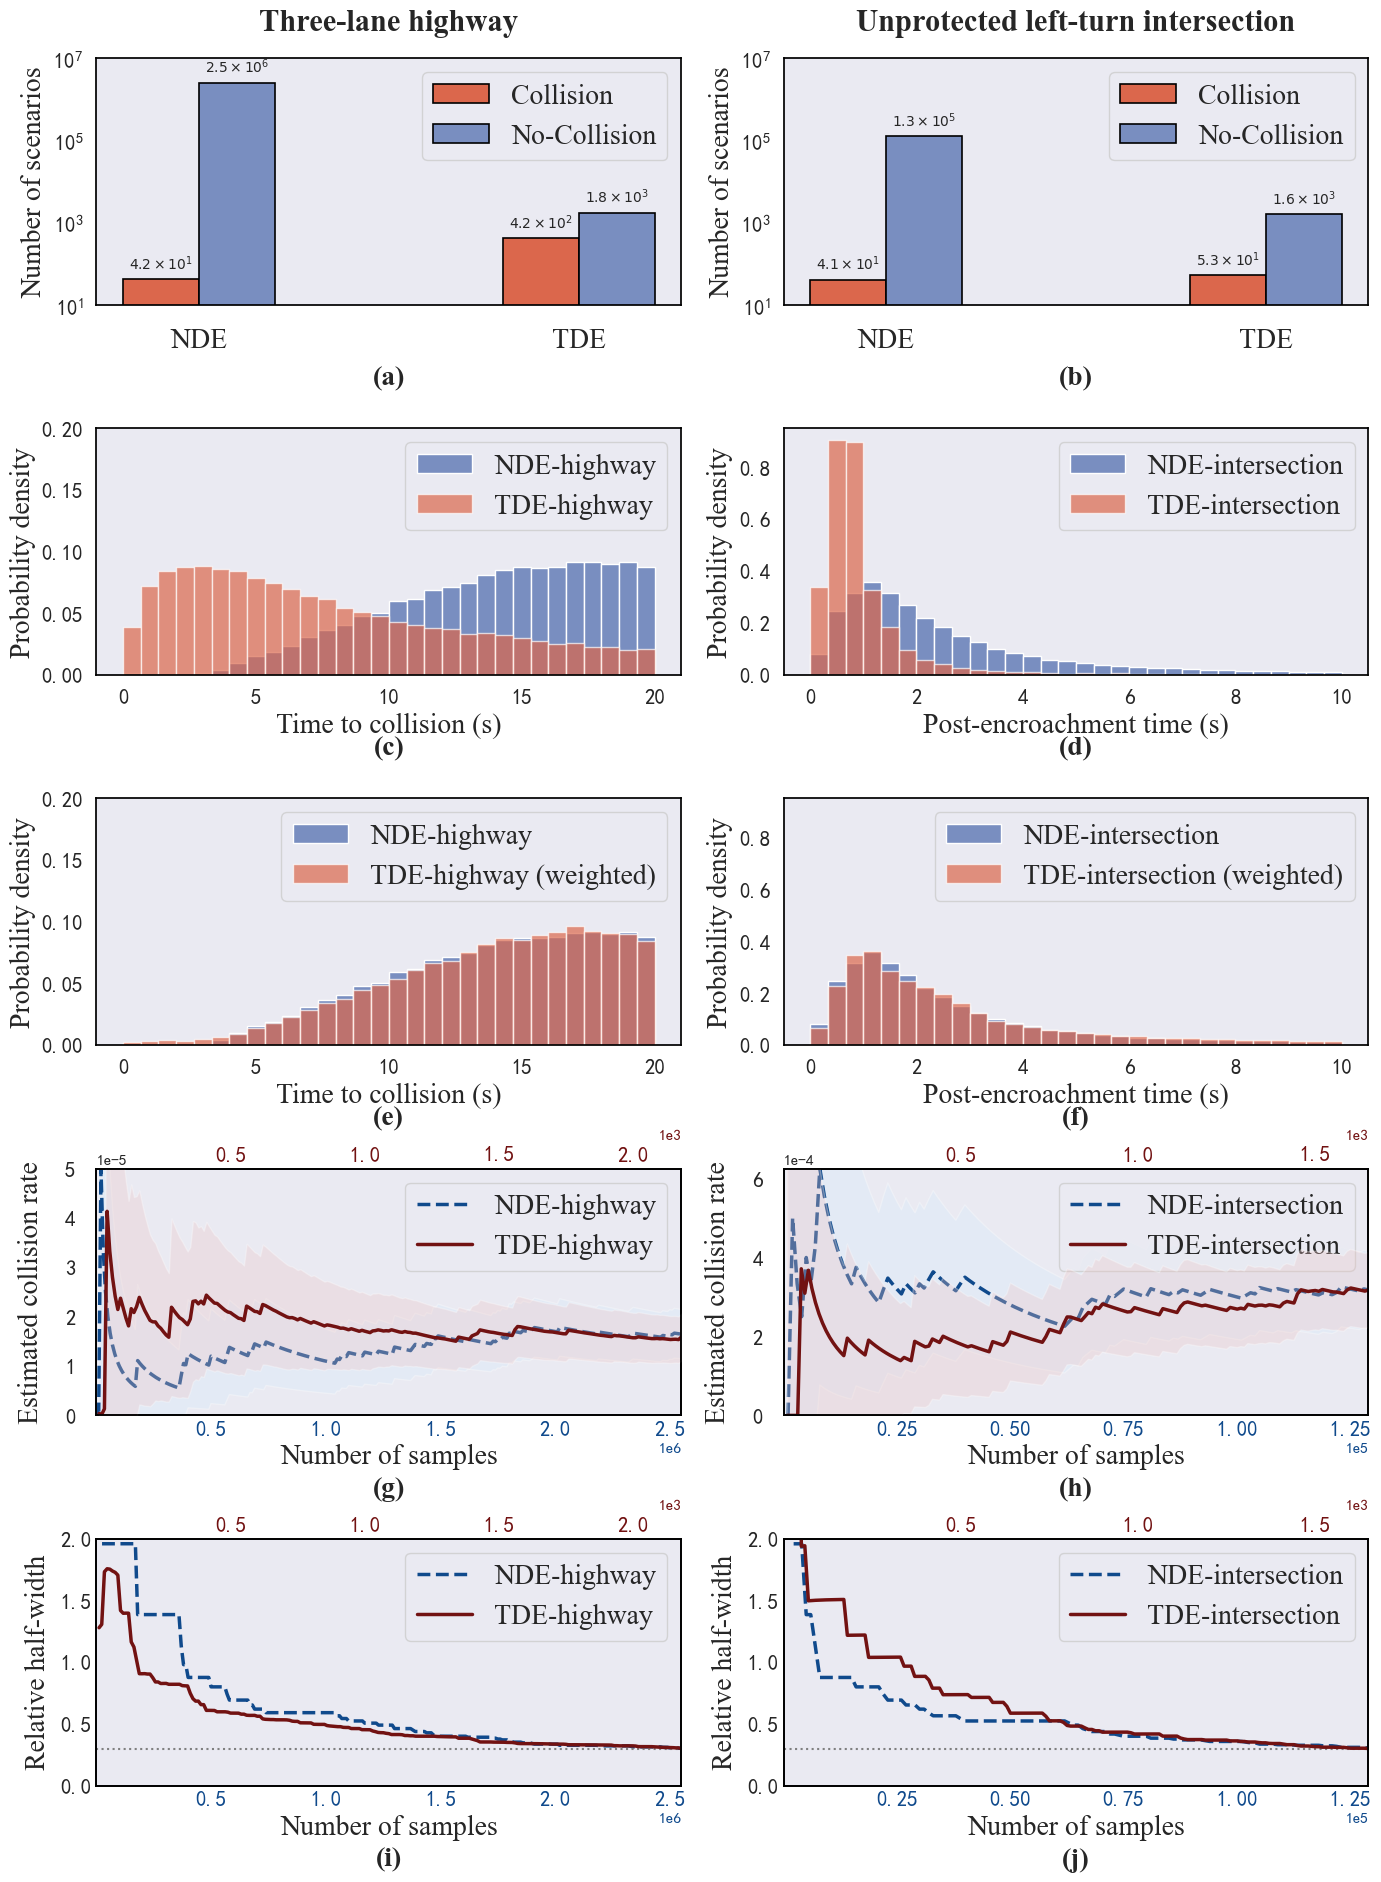

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.formatter.use_locale'] = False
FlowIS_highway=UnbiasedEstimate(NDEresult_highway_org,TDEresult_highway,lable=['NDE-highway','TDE-highway'],NDEinterval=10000,TDEinterval=10)
FlowIS_intersection=UnbiasedEstimate(NDEresult_intersection_org,TDEresult_intersection,lable=['NDE-intersection','TDE-intersection'],NDEinterval=1000,TDEinterval=10)
NDEresult_highway=FlowIS_highway.NDE['data']
TDEresult_highway=FlowIS_highway.TDE['data']
NDEresult_intersection=FlowIS_intersection.NDE['data']
TDEresult_intersection=FlowIS_intersection.TDE['data']

fig, axs = plt.subplots(5, 2, figsize=(14, 19)) 
bar_comparison(axs[0,0],NDEresult_highway,TDEresult_highway,xlabel='Three-lane highway',ylim=(1e1, 1e7))
bar_comparison(axs[0,1],NDEresult_intersection,TDEresult_intersection,xlabel='Unprotected left-turn intersection',ylim=(1e1, 1e7))
hist_plot_simulated(axs[1,0], NDEsample_highway[:,1],TDEsample_unbaised_highway[:,1]-3,
                    labely='Time to collision (s)',ylimt=(0,0.2),legend=['NDE-highway', 'TDE-highway'],bin = 30,ranges = (0, 20))
axs[1,0].xaxis.set_major_locator(ticker.MultipleLocator(5))
hist_plot_unbaised(axs[2,0],NDEsample_highway[:,1],TDEsample_accelerate_highway[:,4],TDEsample_accelerate_highway[:,5],
                   labelx='Time to collision (s)',ylimt=(0,0.2),legend=['NDE-highway', 'TDE-highway (weighted)'],bin = 30,ranges = (0, 20))
axs[2,0].xaxis.set_major_locator(ticker.MultipleLocator(5))
hist_plot_simulated(axs[1,1],NDEsample_intersection[:,5],TDEsample_accelerate_intersection[:,5],
                    labely='Post-encroachment time (s)',ylimt=(0,0.95),legend=['NDE-intersection', 'TDE-intersection'],bin = 30,ranges = (0, 10))
hist_plot_unbaised(axs[2,1],NDEsample_intersection[:,5],TDEsample_unbiased_intersection[:,5],TDEsample_unbiased_intersection[:,6],
                   labelx='Post-encroachment time (s)',ylimt=(0,0.95),legend=['NDE-intersection', 'TDE-intersection (weighted)'],bin = 30,ranges = (0, 10))
FlowIS_highway.info()
FlowIS_intersection.info()
FlowIS_highway.collision_rate(axs[3,0])
FlowIS_highway.half_wide(axs[4,0])
FlowIS_intersection.collision_rate(axs[3,1])
FlowIS_intersection.half_wide(axs[4,1])
for i in range(5):
    for j in range(2):
        axs[i,j].text(0.5, -0.25, f'({chr(97+2*i+j)})', transform=axs[i,j].transAxes, fontsize=20, fontweight='bold', ha='center', va='top',family="Times New Roman")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5) 
fig.savefig(
    r'D:\BaiduSyncdisk\加速测试\方法验证_流向安全关键事件_场景行为联合加速验证框架\PartC\Figure 5.svg',  # 文件名
    format='svg',               # 指定格式为SVG
    bbox_inches='tight',        # 裁剪多余空白
    dpi=600                     # SVG为矢量图，dpi不影响分辨率但可保留该参数
)

In [33]:
# 导入消融实验的结果图
TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\highway_sceneonly_20250904\result.joblib'))
TDEresult_=TDEresult_[:,0]*TDEresult_[:,2]
TDEresult_scene_highway=TDEresult_[TDEresult_<0.11]

TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\highway_behavioronly_20250829\result.joblib'))
TDEresult_=TDEresult_[:,0]*TDEresult_[:,2]
TDEresult_behavior_highway=TDEresult_[TDEresult_<0.05]

TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_sceneonly_20250829\result.joblib'))
TDEresult_=np.array(TDEresult_)
TDEresult_=TDEresult_[:,0]*TDEresult_[:,1]
TDEresult_scene_intersection=TDEresult_[TDEresult_<0.055]

TDEresult_=np.array(joblib.load(r'E:\加速测试仿真数据\FlowIS\simulation\intersection_behavioronly_20250830\result.joblib'))
TDEresult_=np.array(TDEresult_)
TDEresult_=TDEresult_[:,0]*TDEresult_[:,1]
TDEresult_behavior_intersection=TDEresult_[TDEresult_<0.25]


In [34]:
def half_wide_ablation(ax1,NDE,TDE,Scene,Behavior,lables):
    # fig, ax1 = plt.subplots(figsize=(10,5),dpi=600)
    s1=ax1.plot(NDE['x_index'],NDE['half'], '--', color='#104a8c', alpha=1, linewidth=2.5,label=fr'NDE-{lables}')
    s2=ax1.plot(Scene['x_index'],Scene['half'], '-', color='#DB674C', alpha=0.75, linewidth=2.5,label=fr'Scene-{lables}')
    s3=ax1.plot(Behavior['x_index'],Behavior['half'], '-', color='#DB674C', alpha=0.5, linewidth=2.5,label=fr'Behavior-{lables}')
    s4=ax1.plot(TDE['x_index'],TDE['half'], '-', color='#721212', alpha=1, linewidth=2.5,label=fr'TDE-{lables}')


    ax1.set_xlabel('Number of samples',fontsize=20,family="Times New Roman")
    ax1.set_ylabel('Relative half-width',fontsize=20, family="Times New Roman", labelpad=7)
    ax1.tick_params(axis='x',colors='#104a8c', labelsize=15, length=0)
    ax1.tick_params(axis='y', labelsize=15, length=0)
    # xticks1 = ax1.get_xticks()
    # ax1.set_xticks([tick for tick in xticks1 if tick != 0])  

    # ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    # ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax1.grid(False)
    ax1.set_xscale('log')
    ax1.set_xlim(100, len(NDE['col'])*NDE['interval']*10) 
    ax1.set_ylim(0, 2) 

    lns = s1+s2+s3+s4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs,loc='upper right',prop={"family": "Times New Roman", "size": 15})
    ax1.axhline(y=0.3, color='gray', linestyle="dotted")

碰撞率 1.6470588235294116e-05
碰撞率 0.19128440366972477
碰撞率 0.011808461180846119
碰撞率 0.0037247885491216654
碰撞率 0.0003178294573643411
碰撞率 0.03212121212121212
碰撞率 0.009561752988047808
碰撞率 0.002084108671380722


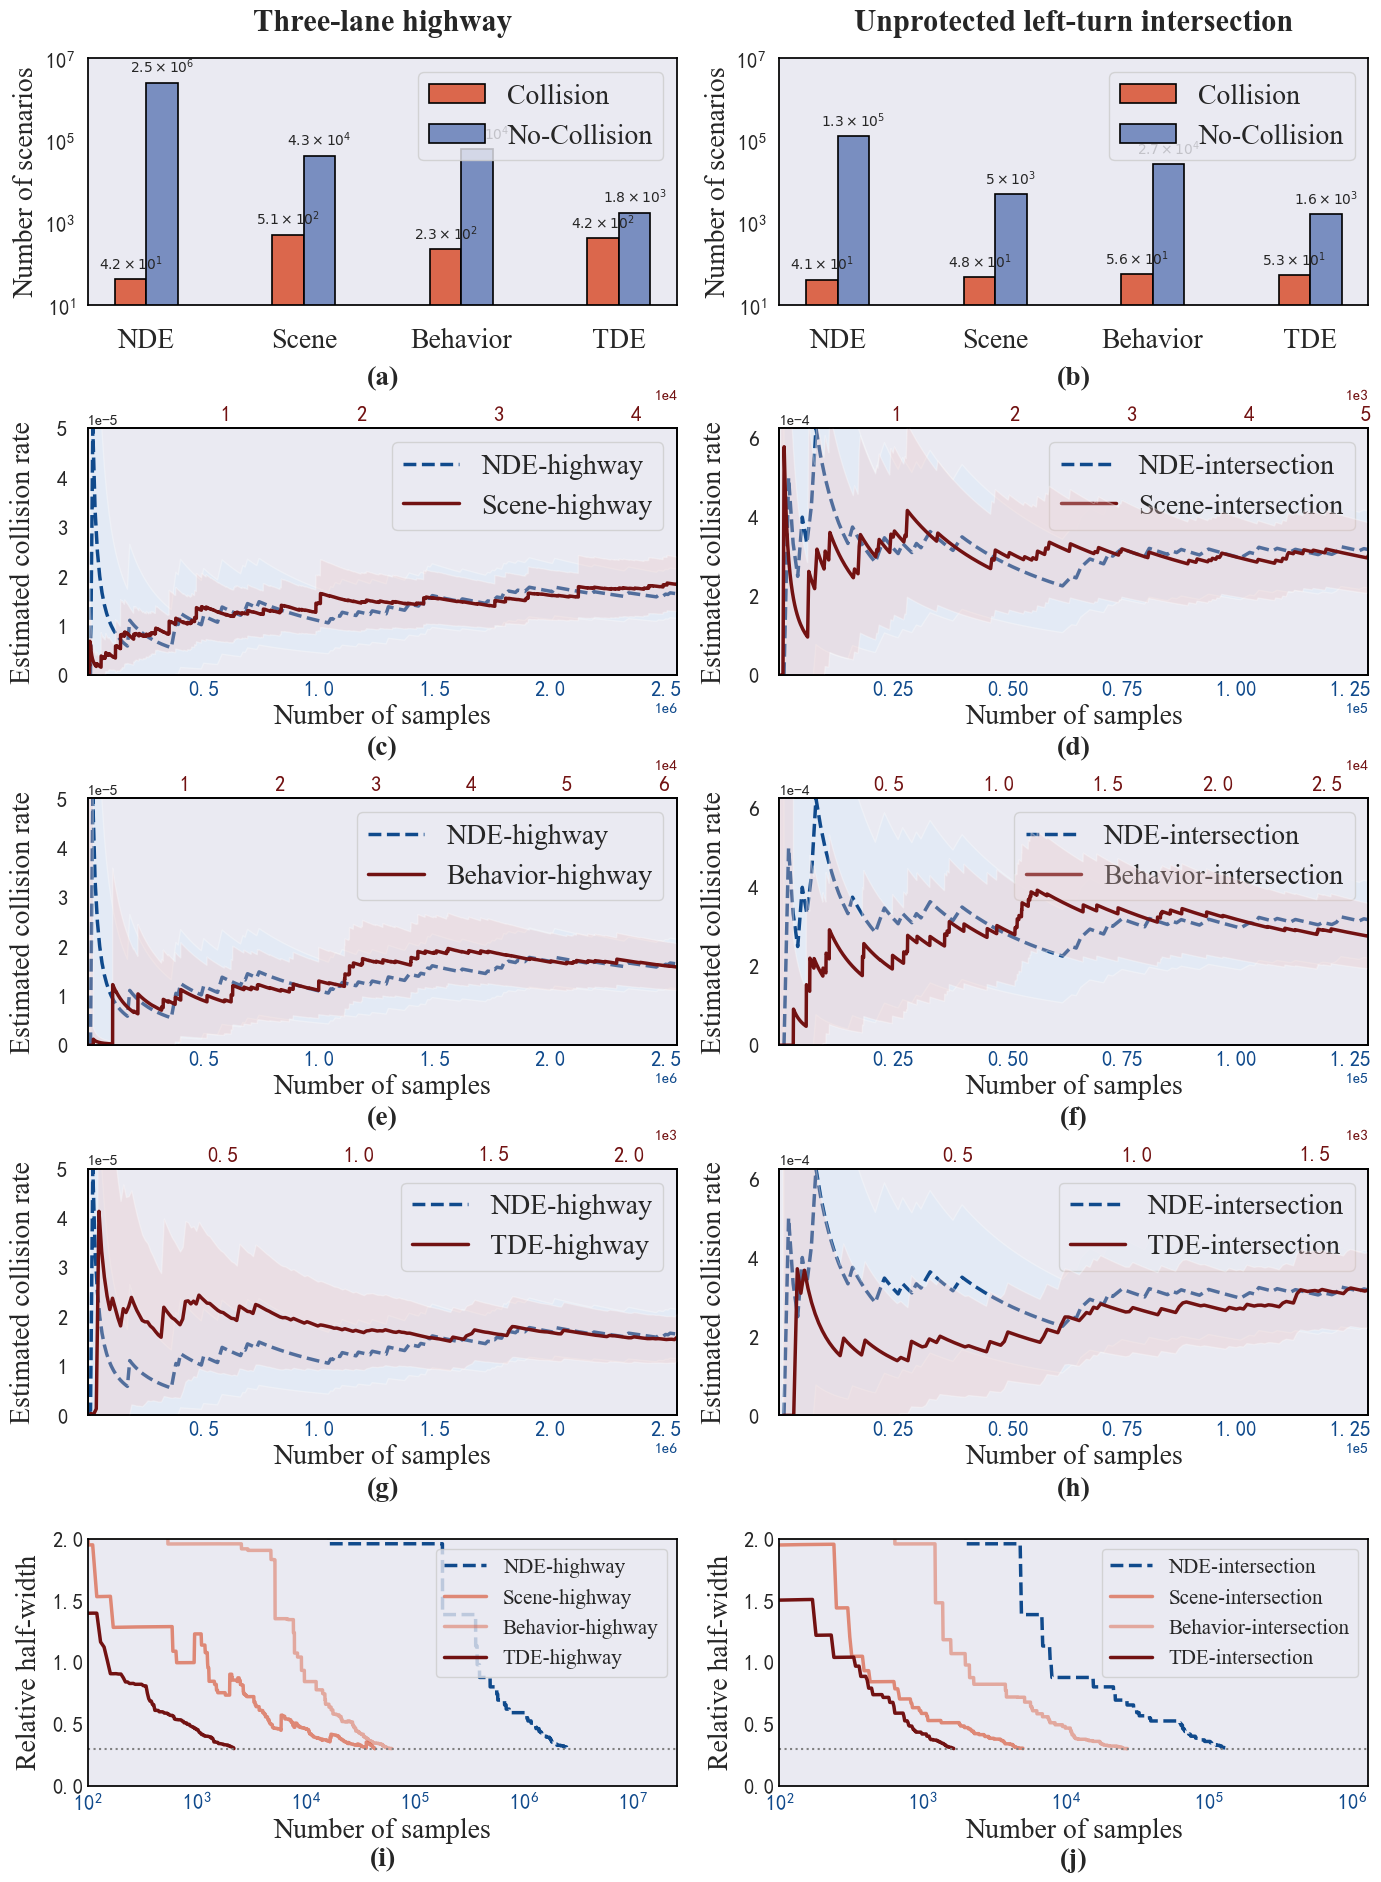

In [35]:
FlowIS_scene_highway=UnbiasedEstimate(NDEresult_highway_org,TDEresult_scene_highway,lable=['NDE-highway','Scene-highway'],NDEinterval=10000,TDEinterval=10)
TDEresult_scene_highway=FlowIS_scene_highway.TDE['data']
FlowIS_behavior_highway=UnbiasedEstimate(NDEresult_highway_org,TDEresult_behavior_highway,lable=['NDE-highway','Behavior-highway'],NDEinterval=10000,TDEinterval=10)
TDEresult_behavior_highway=FlowIS_behavior_highway.TDE['data']
FlowIS_scene_intersection=UnbiasedEstimate(NDEresult_intersection_org,TDEresult_scene_intersection,lable=['NDE-intersection','Scene-intersection'],NDEinterval=1000,TDEinterval=10)
TDEresult_scene_intersection=FlowIS_scene_intersection.TDE['data']
FlowIS_behavior_intersection=UnbiasedEstimate(NDEresult_intersection_org,TDEresult_behavior_intersection,lable=['NDE-intersection','Behavior-intersection'],NDEinterval=1000,TDEinterval=10)
TDEresult_behavior_intersection=FlowIS_behavior_intersection.TDE['data']

fig, axs = plt.subplots(5, 2, figsize=(14, 19)) 
bar_comparison_ablation(axs[0,0],NDEresult_highway,TDEresult_highway,TDEresult_scene_highway,TDEresult_behavior_highway,xlabel='Three-lane highway',ylim=(1e1, 1e7))
bar_comparison_ablation(axs[0,1],NDEresult_intersection,TDEresult_intersection,TDEresult_scene_intersection,TDEresult_behavior_intersection,xlabel='Unprotected left-turn intersection',ylim=(1e1, 1e7))

# FlowIS_scene_highway.info()
FlowIS_scene_highway.collision_rate(axs[1,0])
FlowIS_behavior_highway.collision_rate(axs[2,0])
FlowIS_scene_intersection.collision_rate(axs[1,1])
FlowIS_behavior_intersection.collision_rate(axs[2,1])
FlowIS_highway.collision_rate(axs[3,0])
FlowIS_intersection.collision_rate(axs[3,1])

half_wide_ablation(axs[4,0],FlowIS_highway_new.NDE,FlowIS_highway.TDE,
                   FlowIS_scene_highway.TDE,FlowIS_behavior_highway.TDE,lables='highway')
half_wide_ablation(axs[4,1],FlowIS_intersection_new.NDE,FlowIS_intersection.TDE,
                   FlowIS_scene_intersection.TDE,FlowIS_behavior_intersection.TDE,lables='intersection')
for i in range(5):
    for j in range(2):
        axs[i,j].text(0.5, -0.25, f'({chr(97+2*i+j)})', transform=axs[i,j].transAxes, fontsize=20, fontweight='bold', ha='center', va='top',family="Times New Roman")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5) 
fig.savefig(
    r'D:\BaiduSyncdisk\加速测试\方法验证_流向安全关键事件_场景行为联合加速验证框架\PartC\Figure 6.svg',  # 文件名
    format='svg',               # 指定格式为SVG
    bbox_inches='tight',        # 裁剪多余空白
    dpi=600                     # SVG为矢量图，dpi不影响分辨率但可保留该参数
)

In [36]:
FlowIS_highway.info()
FlowIS_scene_highway.info()
FlowIS_behavior_highway.info()

FlowIS_intersection.info()
FlowIS_scene_intersection.info()
FlowIS_behavior_intersection.info()

仿真数： 2550000 
 加速值： 1.584948538887164e-05 
 仿真数： 2180 
   倍数： 1169.7247706422017
仿真数： 2550000 
 加速值： 1.848418475133529e-05 
 仿真数： 43020 
   倍数： 59.274755927475596
仿真数： 2550000 
 加速值： 1.5844726095204367e-05 
 仿真数： 61480 
   倍数： 41.47690305790501
仿真数： 129000 
 加速值： 0.00031753020889020435 
 仿真数： 1650 
   倍数： 78.18181818181819
仿真数： 129000 
 加速值： 0.00030323241103936635 
 仿真数： 5020 
   倍数： 25.697211155378486
仿真数： 129000 
 加速值： 0.0002785047880157143 
 仿真数： 26870 
   倍数： 4.8008931894305915
